# Практическая работа по распознаванию речи #4: <br> Поиск наилучшей гипотезы распознавания
Задача распознавания речи состоит в поиске наиболее вероятной словной гипотезы по имеющемуся звуковому сигналу. Используя теорему Байеса, формулировку задачи можно написать так:
$$ W^* = \underset{W}{argmax} {P(W|O)} =  \underset{W}{argmax} \sum_i^N{(\log{P(O|w_i)} + \log{P(w_i|w_{i-1}, w_{i-2},..))}}$$
Где: 
* $O$ - звук
* $W$ - словная гипотеза распознавания 
* $W^*$ - лучшая гипотеза распознавания
* $P(W|O)$ - вероятность гипотезы распознавания при условии наблюдения $O$
* $N$ - количество слов в гипотезе
* $w_i$ - i'ое слово в гипотезе
* $P(O|w_i)$ - акустическое правдоподобие слова (выводится из предсказания акустической моделью)
* $P(w_i|w_{i-1}, w_{i-2},..)$ - языковая вероятность слова при условии контекста (предсказывается языковой моделью)


В прошлых лабораторных работах были изучены акустическая и языковая модели. Акустическая модель предсказывает вероятность принадлежности кадра некоему акустическому классу (фонеме). Языковая модель предсказывает априорную вероятность последовательности слов. Пришло время разобраться, как соединить эти части в одну систему и получить итоговый результат распознавания. 





### Основная часть (14 баллов) данной практической работы состоит из двух частей: 
* знакомство с Weighted Finite State Transducer (WFST)
* WFST декодинг в ASR системе

### Дополнительная часть 
* тюнинг параметров beam search (2 балла)

## Полезные ссылки: 
* Наиболее популярная библиотека WFST - [OpenFst](https://www.openfst.org/twiki/bin/view/FST/WebHome)
* Библиотека для визуализации - [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html)
* Алгоритм обхода графа в ширину - [BFS](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%85%D0%BE%D0%B4_%D0%B2_%D1%88%D0%B8%D1%80%D0%B8%D0%BD%D1%83)

In [2]:
!python3 --version 

Python 3.13.0


In [4]:
!pip install graphviz kenlm kaldiio jiwer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for kenlm: filename=kenlm-0.2.0-cp311-cp311-macosx_15_0_arm64.whl size=507827 sha256=84221da0b1d096e4a60693dc7b3df1d0ea236db18b68371b55e7794d21641eeb
  Stored in directory: /Users/nancyblack/Library/Caches/pip/wheels/0f/40/64/979330b5c224c7f78a11a0bf592128af215178cb1207d9ca43
Successfully built kenlm


In [5]:
import numpy as np
import time
import os
import abc

from typing import List, Dict, Union, Set, Any, Optional, Tuple
from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import graphviz
import kenlm 
import jiwer
from kaldiio import ReadHelper

# 1. Weighted Finite State Transducer (WFST)



Из определения в wiki [Weighted Finite State Transducer (Взвешенный конечный автомат с выходом)](https://en.wikipedia.org/wiki/Finite-state_transducer) следует, что главная задача FST - это переводить символы из входного алфавита в соответствующие им символы из выходного алфавита. Например, с помощью FST можно перевести последовательность фонем в последовательность слов. Конечный автомат будет менять свое состояние при обработке последовательности входных символов (фонем). Когда он соберет из входных фонем корректную транскрипцию слова, то выдаст это слово на выход. 

Однако не всегда можно однозначно перевести последовательность фонем в слова (некоторые слова произносятся одинаково, а пишутся по-разному), поэтому для распознавания речи надо использовать не простой FST, а взвешенный. WFST позволяет не только перевести входные символы в выходные, но и оценить вес такого перевода. Чем больше вес, тем хуже гипотеза.  

Напишем собственную реализацию WFST.


### AbstractWFST
AbstractWFST -- это базовый интерфейс нашего WFST. В нем заданы основные методы, через которые мы будем работать с wfst  
* get_start - возвращаяет стартовое состояние конечного автомата.
* final_score - вес завершения работы в данном состоянии. В некоторых состояниях завершить обработку невозможно, в таких случаях final weight  будет равен бесконечности.
*  transduce - совершает переход из текущего состояния в следующее, соответствующее переходу по символу ilabel. Возвращает выходной символ, вес перехода и следующее состояние.  




 

In [6]:
class AbstractWFST(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def get_start(self) -> Any:
        """Return start state"""
    
    @abc.abstractmethod
    def final_score(self, state: Any) -> float:
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""
           
    @abc.abstractmethod
    def transduce(self, state: Any, ilabel: str) -> Tuple[Tuple[str, float, Any]]:
        """Transduce ilabel to olabel. 
        return all available olabels for this state and ilabel pair
        return type - ((olabel1, weight1, nextstate1), 
                       ((olabel1, weight1, nextstate1), 
                       ...)"""

### SymbolsMap

Для того, чтобы задать WFST, первым делом нам понадобятся таблицы входных и выходных символов. Для задания таблиц будем использовать класс SymbolsMap. Данный класс служит для маппинга символов на индексы и обратно. 

In [7]:
class SymbolsMap:
    def __init__(self, id2symbol: Optional[Dict[int, str]] = None, symbol2id: Optional[Dict[str, int]] = None):
        assert id2symbol is not None or symbol2id is not None, f"One id2symbol or symbol2id must be not None"
        assert id2symbol is None or symbol2id is None, f"Only one One id2symbol or symbol2id can be not None"
        if id2symbol is None:
            self.id2symbol = {i:s for s,i in symbol2id.items()}
        elif isinstance(id2symbol, dict):
            self.id2symbol = id2symbol
        elif isinstance(id2symbol, list):
            self.id2symbol = {i:s for i, s in enumerate(id2symbol)}
        else:
            raise RuntimeError(f"unknown type {type(id2symbol)=}")
            
        if symbol2id is None:
            self.symbol2id = {s:i for i, s in self.id2symbol.items()}
        else:
            self.symbol2id = symbol2id   
                
        assert self.id2symbol[0] == '<eps>', f"wrong {self.id2symbol}"

    def get_id(self, symbol: str):
        return self.symbol2id[symbol]
        
    def get_symbol(self, id: int):
        return self.id2symbol[id] 
    
    @classmethod
    def from_file(cls, fname):
        """read symbols table from file
        format: 
            word id
            word2 id2
            ...
        """
        with open(fname) as f:
            s2i = {s:int(i) for s, i in map(str.split, f.readlines())}
        return cls(symbol2id=s2i)

### Arc и ILabelIndexedArcs
Переходы внутри FST будем описывать с помощью класса, инкапсулирующего информацию о входном/выходном индексе символа, весе перехода и следующем состоянии FST. Поскольку дуги мы будем хранить отдельно для каждого состояния, информация о текущем состоянии в дуге не нужна. 

Для быстрого выбора нужной дуги создадим специальную коллекцию ILabelIndexedArcs. Данная коллекция хранит дуги таким образом, чтобы выбор дуги по входному символу осуществлялся за O(1). 


In [8]:
@dataclass
class Arc:
    """Arc in WFST"""
    ilabel: int
    olabel: int
    weight: float
    nextstate: Any

class ILabelIndexedArcs:
    def __init__(self, arcs: Optional[List[Arc]] = None):
        self.ilabel2arclist = defaultdict(list)
        if arcs is not None:
            for arc in arcs:
                self.add_arc(arc)

    def add_arc(self, arc: Arc):
        self.ilabel2arclist[arc.ilabel].append(arc)

    def get_arcs_by_ilabel(self, ilabel: int):
        return self.ilabel2arclist[ilabel]

    def arcs(self) -> List[Arc]:
        """Return all arcs"""
        all_arcs = []
        # TODO
        # реализуйте функцию, которая возвращает все дуги, хранящиеся в данной коллекции
        #raise NotImplementedError()
        # !!!!!!!!!!!!
        all_arcs = [arc for arc_list in self.ilabel2arclist.values() for arc in arc_list]
        return all_arcs 

    def __str__(self):
        return "ILabelIndexedArcs([" + ", ".join(f"{a}" for a in self.arcs()) + "])"
        
    def __repr__(self):
        return str(self)

In [9]:
# test 1.a
def test_ILabelIndexedArcs():
    # проверка что arcs работает правильно 
    arcs = [Arc(i, -i, i/100, i+100) for i in range(10)]
    c = ILabelIndexedArcs(arcs)
    arcs2 = c.arcs()
    
    assert len(arcs) == len(arcs2), f"{len(arcs)=}, {len(arcs2)=}\n{arcs} != {c.arcs()}"
    for a in arcs2:
        assert a in arcs, f"{a=} not in {arcs=}"
    print('Test 1.a passed')
test_ILabelIndexedArcs()    

Test 1.a passed


### WFST 
Все готово для создания взвешенного конечного автомата. Класс WFST состоит из таблицы входных и выходных символов, списка состояний и коллекции дуг для каждого, а также множества финальных состояний. 

In [10]:
class WFST(AbstractWFST):
    def __init__(self, 
                 isymbols: Optional[SymbolsMap] = None, 
                 osymbols: Optional[SymbolsMap] = None):
        self.start = 0
        self.states = [0]
        # состояния, в которых может завершиться декодирование без какого либо штрафа 
        self.final_states = set() 
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.state2arcs = defaultdict(ILabelIndexedArcs)

    def get_start(self):
        """return start state"""
        return self.start
        
    def final_score(self, state_id: int):
        """return the weight of decoding completion in state_id"""
        # TODO 
        # верните вес завершения декодирования в state_id 
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!
        if state_id in self.final_states:
            return 0.0
        else:
            return float('inf')
       
    def transduce(self, state, ilabel: str) -> Tuple[Tuple[str, float, int]]:
        """transitions wfst to next state by 'ilabel' input symbol, except when the input symbol is <eps>.
        Returns all possible output results as a tuple of triples (olabel, weight, nextstate)."""
        assert self.isymbols is not None and self.osymbols is not None, f"Cannot transduce w/o both symbols tables" 
        if ilabel == '<eps>':
            # skip <eps> input
            return ((ilabel, 0, state), )
        label_id = self.isymbols.get_id(ilabel)
        # TODO 
        # верните все возможные результаты перехода из текущего состояния по входу ilabel
        # результат должен выглядеть так: tuple(("слово", 0.1, 2), ("другоеслово", 10, 4), ...)
        #raise NotImplementedError()
        # !!!!!!!!!!!!
        arcs_container = self.state2arcs[state]
        arcs = arcs_container.get_arcs_by_ilabel(label_id)
        transductions = [(self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel,
                          arc.weight, arc.nextstate) for arc in arcs]
        return tuple(transductions)
    
    def set_final(self, state: int):
        """sets the final weight for the state to zero"""
        # TODO добавьте возможность завершать декодирование в state
        #raise NotImplementedError()
        # !!!!!!!!!!!
        self.final_states.add(state)
        
    def new_state(self):
        """Create new state id and return it"""
        # TODO 
        # добавьте в конечный автомат новое состояние и верните его id 
        #raise NotImplementedError()
        # !!!!!!!!
        state_id = max(self.states) + 1
        self.states.append(state_id)
        return state_id
    
    def add_arc(self, state_from: int, arc: Arc):
        """adds a new arc for this state"""
        # TODO 
        # добавьте в конечный автомат новых переход arc, выходящий из state_from 
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!
        self.state2arcs[state_from].add_arc(arc)
    
    def to_dot(self):
        """Visualize the WFST""" 
        dot = graphviz.Digraph()
        for s in self.states:
            dot.node(str(s))
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                il = self.isymbols.get_symbol(arc.ilabel) if self.isymbols is not None else arc.ilabel
                ol = self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel
                dot.edge(str(state_from), str(arc.nextstate), label=f"{il}:{ol}:{arc.weight:.2f}")
        return dot
    

In [13]:
# test 1.b
def test_WFST():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'б', 'д'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    # new_state
    en2ru_final = en2ru.new_state()
    assert en2ru_final == 1 , f'start - zero, next state - one, next - two ...'
    assert en2ru.new_state() == 2, f'start - zero, next state - one, next - two ...'
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 2, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 3, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    #display.display(en2ru.to_dot())

    # final_score # set_final
    assert en2ru.final_score(en2ru.get_start()) == float('inf')
    assert en2ru.final_score(en2ru_final) == 0
    en2ru.set_final(en2ru.get_start())
    assert en2ru.final_score(en2ru_final) == en2ru.final_score(en2ru.get_start()) == 0

        
    # transduce # add_arc
    assert en2ru.transduce(en2ru.get_start(), 'd') == tuple() , "Cannot transduce 'd' from start state. output must be zero len tuple"
    assert en2ru.transduce(en2ru.get_start(), 'b') == (('б', 1.0, en2ru_final), ) , "Arc(1, 2, 1.0, en2ru_final)"
    assert en2ru.transduce(en2ru.get_start(), 'u') == (('ю', 3.0, en2ru_final), ) , "Arc(3, 1, 3.0, en2ru_final)"
    assert en2ru.transduce(en2ru_final, 'd') == (('д', 2.0, en2ru.get_start()), ) , "Arc(2, 3, 2.0, en2ru.get_start())"
    
    print('test 1.b passed')
test_WFST()

test 1.b passed


## wfst композиция 


Над WFST определен большой набор различных операций, реализация большинства из которых является сложной алгоритмической задачей. Важной для распознавания речи операцией является [композиция](https://www.openfst.org/twiki/bin/view/FST/ComposeDoc) набора различных wfst. 

OpenFST дает следующее определение композиции:
 
"This operation computes the composition of two transducers. If A transduces string x to y with weight a and B transduces y to z with weight b, then their composition transduces string x to z with weight a ⊗ b."

Другими словами, результатом композиции является wfst, применение которого к входной последовательности даст такой же результат, как и последовательное применение композируемых wfst. 

Хорошим примером композиции различных WFST является граф распознавания в гибридных системах распознавания речи. Такой граф является результатом композиции четырех wfst:
* H - Hidden Markov Model wfst (переводит акустические классы, предсказанные с помощью AM, в трифоны)
* С - Context-dependency transducer (переводит трифоны (тройки (leftcontext,phone,rightcontext)) в фонемы)
* L - lexicon (переводит фонемы в слова)
* G - ngram lm (оценивает вероятность последовательностей слов)
 
Итого граф распознавания можно выразить с помощью следующей формулы:
$$ HCLG = H⊗C⊗L⊗G $$ 
где ⊗ - оператор композиции двух wfst. Подробнее про граф распознавания можно почитать в [документации к фреймворку kaldi](https://kaldi-asr.org/doc/graph.html)


Композиция позволяет объединить много обработчиков в один большой граф, что несомненно является большим плюсом для построения продакшн решений. Но у такого подхода есть и минусы - процесс подготовки графа очень сложен и требует множества оптимизаций. Это усложняет любые эксперименты и модификации системы. В данной работе мы не будем реализовывать честную композицию графа, а будем считать композицию "On the Fly". То есть сделаем обертку, реализующую интерфейс AbstractWFST, состоянием которой будет Tuple состояний всех композируемых wfst, а метод transduce будет последовательно проходить через эти wfst. Тем самым, по определению композиции, наш класс будет эквивалентен честной композиции.  



In [14]:
class OnTheFlyCompose(AbstractWFST):
    def __init__(self, wfsts: List[AbstractWFST]):
        # !!!Attention!!! wfsts - это лист AbstractWFST, а не WFST. 
        # Для работы с wfsts истользуйте только методы из AbstractWFST
        self.wfsts = wfsts

    def get_start(self):
        return tuple(fst.get_start() for fst in self.wfsts)

    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        # TODO 
        # посчитайте финальный скор для state
        # результат композиции может завершить обработку только в тех стейтах, где все wfsts будут в финальных состояниях
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!!!
        return sum(fst.final_score(s) for fst, s in zip(self.wfsts, state))
    
    def _transduce(self, state: Tuple[Any], ilabel: str) -> List[Tuple[List[str], float, List[int]]]:
        assert len(self.wfsts) == len(state)
        # Найдите все возможные гипотезы перевода ilabel с помощью композиции всех self.wfsts
        # Последовательно пройдите через все self.wfsts, расширяя список гипотез и дополняя гипотезы новыми слоями 
        # Верните результат в виде списка гипотез. 
        # Каждая гипотеза содержит три элемента: 
        #   0. список символов со ВСЕХ прошедших слоев композиции 
        #   1. суммарный вес гипотезы 
        #   2. список состояний, в которые перешли self.wfsts 

        # Одна стартовая гипотеза. Корень для всех гипотез.
        # Еще никакой wfst не применен, символ только ilabel, вес стартовый, стейтов еще нет. 
        hyps_per_layer = [([ilabel], 0, [])]  
        for fst, s in zip(self.wfsts, state):
            new_hyps = []
            # TODO 
            # примените fst.transduce ко всем гипотезам из hyps_per_layer
            # постепенно разветвляя их и сохраняя в new_hyp
            # на вход подайте выход последнего из уже обработаных слоев 
            #raise NotImplementedError()
            # !!!!!!!!!
            for ls, w, ss in hyps_per_layer:
                for olabel, ow, os in fst.transduce(s, ls[-1]):
                    new_ls, new_w, new_ss = list(ls), w + ow, list(ss)
                    
                    new_ls.append(olabel)
                    new_ss.append(os)
                    new_hyps.append((new_ls, new_w, new_ss))
                    
            hyps_per_layer = new_hyps
            
        return hyps_per_layer

    def transduce(self, state: Tuple[Any], ilabel: str):
        hyps_per_layer = self._transduce(state, ilabel)
        # выходной символ transduce в композиции - это выходной символ самого последнего wfst 
        return tuple((ls[-1], w, tuple(ss)) for ls, w, ss in hyps_per_layer)
    

In [15]:
def test_OnTheFlyCompose():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'д', 'б'])
    en_U = SymbolsMap(id2symbol=['<eps>', 'B', 'D', 'U'])
    ru_U = SymbolsMap(id2symbol=['<eps>', 'Ю', 'Д', 'Б'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    en2ru_final = en2ru.new_state()
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 3, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 2, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(2, 0, 0.1, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    # display.display(en2ru.to_dot())

    # OnTheFlyCompose одного fst работает так же как и этот fst
    comp = OnTheFlyCompose([en2ru])
    for s in (0, 1):
        for il in 'bdu':
            hyps1 = en2ru.transduce(s, il)
            hyps2 = comp.transduce((s,), il)
            for h in hyps2:
                # only one state
                assert len(h[2]) == 1, f"{hyps2=}"
            hyps2_flatten = tuple((l, w, ss[0]) for l,w,ss in hyps2)
            assert hyps1 == hyps2_flatten, f"{hyps1=} {hyps2_flatten=}"
        
        scores = [float('inf'), 0]
        your_score = comp.final_score((s,))
        assert your_score == scores[s], f"Your score = {your_score}, correct = {scores[s]}"

    # create second transducer
    ru2en = WFST(isymbols=ru_l, osymbols=en_U)
    ru2en_final = ru2en.new_state()
    ru2en.set_final(ru2en_final)
    ru2en.add_arc(ru2en.get_start(), Arc(3, 1, 10.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 20.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 30.0, ru2en.get_start()))
    ru2en.add_arc(ru2en_final, Arc(1, 3, 40.0, ru2en.get_start()))
    
    # you can use this line to visualize
    # display.display(ru2en.to_dot())

    # композиция двух работает как последовательное применение каждого 
    comp = OnTheFlyCompose([en2ru, ru2en])
    hyps = comp.transduce((0, 0), 'b')
    assert hyps == (('B', 11.0, (1, 1)), ) , f"{hyps =}"
    hyps = comp.transduce((1, 1), 'd')
    assert hyps == (('D', 22.0, (0, 1)), ('D', 32.0, (0, 0))) , f"{hyps =}"
    hyps = comp.transduce((0, 1), 'd')
    assert hyps == (('<eps>', 0.1, (0, 1)), ) , f"{hyps =}"
    # Проверка правильности расчетов final_score
    your_score = comp.final_score((0, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((0, 1))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 1))
    assert your_score == 0, f"Your score = {your_score}, correct = {0}"
    print('Test 1.c passed')
    
    
test_OnTheFlyCompose()

Test 1.c passed


# 2. WFST декодинг в ASR системе
Отлично, код WFST готов, теперь необходимо собрать граф распознавания и написать поиск наилучшей гипотезы 




In [16]:
# Сначала подготовим нужные нам таблицы символов
AM_PHONES = {0: 'pau', 1: 'aa', 2: 'ae', 3: 'ah', 4: 'ao', 5: 'aw', 6: 'ax', 7: 'ax-h', 8: 'axr', 9: 'ay', 10: 'b', 
             11: 'bcl', 12: 'ch', 13: 'd', 14: 'dcl', 15: 'dh', 16: 'dx', 17: 'eh', 18: 'el', 19: 'em', 20: 'en', 
             21: 'eng', 22: 'er', 23: 'ey', 24: 'f', 25: 'g', 26: 'gcl', 27: 'hh', 28: 'hv', 29: 'ih', 30: 'ix', 
             31: 'iy', 32: 'jh', 33: 'k', 34: 'kcl', 35: 'l', 36: 'm', 37: 'n', 38: 'ng', 39: 'nx', 40: 'ow', 
             41: 'oy', 42: 'p', 43: 'pcl', 44: 'q', 45: 'r', 46: 's', 47: 'sh', 48: 't', 49: 'tcl', 50: 'th', 
             51: 'uh', 52: 'uw', 53: 'ux', 54: 'v', 55: 'w', 56: 'y', 57: 'z', 58: 'zh'}

# таблица фонем для wfst 
def create_phones_txt(fname='exp/phones.txt'):
    fname = Path(fname) 
    fname.parent.mkdir(exist_ok=True, parents=True)
    with open(fname, 'w') as f:
        f.write('<eps> 0\n') # !! shift all ids by one !! 
        for i, p in sorted(AM_PHONES.items()):
            f.write(f'{p} {i+1}\n')
create_phones_txt()


In [19]:
# Загрузим подготовленный лексикон из датасета 
def load_lexicon_file(fname='timit/TIMITDIC.TXT', words_limit=-1):
    """generator running through the 'fname' phonetic dictionary 
    yield (word: str, phones: List[str])"""
    num = 0
    with open(fname) as f:
        for line in map(str.strip, f.readlines()):
            if line.startswith(';'):
                continue
            word, trans, _ = line.split('/')
            # remove ~adj suffix 
            word = word.split('~')[0].strip() 
            # remove stress factor
            trans = [t[:-1] if t[-1].isdigit() else t for t in trans.split()]
            yield word, trans
            num += 1
            if words_limit == num:
                break

In [20]:
# подготовим таблицу слов
def create_words_txt(fname='exp/words.txt', dic_fname='timit/TIMITDIC.TXT'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    words = ['<eps>'] + [w for w, _ in sorted(load_lexicon_file(dic_fname))] + ['<s>', '</s>']
    with open(fname, 'w') as f:
        f.write(''.join(f'{w} {i}\n' for i, w in enumerate(words)))
create_words_txt()

# T transducer

Создадим первый wfst. 

В гибридном пайплайне системы распознавания речи задача первых двух wfst (H и C) - это перевести предсказанные с помощью акустической модели классы в последовательность фонем. В нашем случае все значительно легче, так как АМ (из работы №3) уже учится предсказывать фонемы, поэтому мы не будем использовать HС трансдьюсеры. 

В этой работе будет использоваться простой трасдьюсер T. Этот wfst нужен для преобразования вероятностей фонем, которые оценивает AM, в их правдоподобие. Используя теорему Баеса, сделать это преобразование легко. Надо просто добавить к скорам фонем их априорную вероятность.


T.wfst состоит из одного состояния и N петель, где N - это количество фонем. Каждая петля соответствует определенной фонеме и хранит логарифм ее априорной вероятности.

![image](resources/lab4/H_example.svg)

In [67]:
def create_t_wfst(prior_file='resources/lab4/phone.priors', phones_fname='exp/phones.txt'):
    """Create T.wfst. just transduce AM probability to AM likelihood (Bayes theorem)
    """
    symbols = SymbolsMap.from_file(phones_fname)
    t_fst = WFST(isymbols=symbols, osymbols=symbols)
    s = t_fst.get_start()
    t_fst.set_final(s)
    with open(prior_file) as f:
        for ph, prior in map(str.split, f.readlines()):
            log_prior = np.log(float(prior))
            ph_id = symbols.get_id(ph)
            t_fst.add_arc(s, Arc(ph_id, ph_id, log_prior, s))
    return t_fst
#create_t_wfst().to_dot()

# L transducer

Lwfst - это WFST, который преобразует входные последовательности фонем в слова.

Например, `pau pau ae1 ae1 ae1 ae1 ae1 ae1 r pau pau pau y y y y eh1 s s s pau` -> `air yes`

Чтобы контролировать количество слов в выходной гипотезе, в L добавляется два веса: 
* word_insertion_penalty - штраф за добавление слова 
* stay_in_silence_penalty - штраф за пропуск паузы (фонемы pau)

Пример Lwfst, построенного для слов `'em` `-knacks`, с параметрами word_insertion_penalty=0.5, stay_in_silence_penalty=0.01

![image](./resources/lab4/L_example.svg)

Фонема паузы pau обрабатывается особым способом: L.fst может пропускать ее, не генерируя ничего на выходе. Также у окончания каждой транскрипции слова есть две отдельные дуги, возвращающие FST в стартовое состояние. Это нужно для того, чтобы была возможность как обработать подряд идущие дупликаты последней фонемы на конце слова, так и перейти в стартовое состояние всего по одной финальной фонеме. 

In [24]:
def create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                           phones_fname='exp/phones.txt', 
                           words_fname='exp/words.txt', 
                           words_limit=-1,
                           word_insertion_penalty=0.5, 
                           stay_in_silence_penalty=0.01):
    isymbols = SymbolsMap.from_file(phones_fname)
    osymbols = SymbolsMap.from_file(words_fname)
    sil_id = isymbols.get_id('pau')
    l_wfst = WFST(isymbols=isymbols, osymbols=osymbols)
    start = l_wfst.get_start()
    ### Пропуск скольких угодно фонем тишины
    l_wfst.add_arc(start, Arc(sil_id, 0, stay_in_silence_penalty, start))
    # Стартовое состояние также является и финальным
    l_wfst.set_final(start)
    
    for word, trans in load_lexicon_file(dic_fname, words_limit=words_limit):
        tran_ids = [isymbols.get_id(t) for t in trans]
        word_id = osymbols.get_id(word)
        # TODO 
        # Добавьте последовательные дуги в wfst, определяющие транскрипцию слова
        # Все дуги, кроме последней, на выходе имеют <eps>
        # Последняя дуга выводит word_id и возвращает конечный автомат в стартовое (оно же финальное) состояние
        # Каждая фонема может тянуться от 1 до inf кадров, поэтому помимо переходов в новое состояние, должны быть еще петли 
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        prev_state = start
        for i, phone_id in enumerate(tran_ids):
            state = l_wfst.new_state()
            l_wfst.add_arc(prev_state, Arc(phone_id, 0, 0, state))
            l_wfst.add_arc(state, Arc(phone_id, 0, 0, state))
            if i+1==len(tran_ids):
                l_wfst.add_arc(prev_state, Arc(phone_id, word_id, word_insertion_penalty, start))
                l_wfst.add_arc(state, Arc(phone_id, word_id, word_insertion_penalty, start))
            prev_state = state   
        
    return l_wfst
#create_Lwfst_from_file(words_limit=2, word_insertion_penalty=0.5, stay_in_silence_penalty=0.01).to_dot()

In [25]:
def test_l_wfst():
    l_wfst = create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                                    word_insertion_penalty=1.0, stay_in_silence_penalty=0.01)
    start = l_wfst.get_start()
    hyps = l_wfst.transduce(start, 'pau')
    loop_hyp = [(l, w, s) for l, w, s in hyps if s == start]
    assert (len(loop_hyp) == 1 
            and loop_hyp[0][0] == '<eps>' 
            and loop_hyp[0][1] == 0.01), f"{hyps}\n skip pause test failed"
    # смотрим, что поданная на вход транскрипция корректно переводится в слово
    # количество подряд идущих одинаковых фонем постепенно увеличивается от одной до 6
    for i, (word, trans) in enumerate(tqdm(load_lexicon_file('timit/TIMITDIC.TXT', words_limit=100), total=100)):
        hyps = [('', 0, l_wfst.get_start()), ]
        # Breadth First Search
        for t in [t for t in trans for _ in range(i//20+1)]:
            # t repeated many times
            new_hyps = []
            for prev_l, prev_w, prev_s in hyps: 
                new_hyps.extend([(f"{prev_l} {l}", prev_w + w, s) for l,w,s in l_wfst.transduce(prev_s, t)])
            hyps = new_hyps
        # choose only final hyp
        # ограничение веса нужно, чтобы отсечь гипотезы где комбинация других слов мапится на теже фонемы
        hyps = [(l, w, s) for l, w, s in hyps if l_wfst.final_score(s) != float('inf') and w == 1.0]
       
        assert len(hyps) == 1 or len(trans) == 1 , f"Test failed for word \"{word}\" {hyps=}"
        assert hyps[0][0].replace('<eps>', ' ').split() == [word], f"Test failed for word {word} {hyps=}"
        assert hyps[0][1] == 1.0, f"Test failed for word {word} {hyps=}"
        assert hyps[0][2] == start, f"Test failed for word {word} {hyps=}"       
    print("test 2.a passed")
test_l_wfst()

  0%|          | 0/100 [00:00<?, ?it/s]

test 2.a passed


# Поиск наилучшей гипотезы распознавания с помощью beam search

Для того, чтобы найти результат распознавания с помощью акустической модели и графа распознавания, надо выполнить поиск наилучшей гипотезы в графе. Для поиска лучшего пути будем использовать [лучевой поиск (Beam Search)](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D1%87%D0%B5%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA). В основе этого алгоритма лежит обход графа в ширину, но на каждом шаге рассматриваются только наиболее "хорошие" гипотезы, а остальные уничтожаются. Такая эвристика позволяет значительно ускорить процесс декодирования, но не всегда находит наилучший путь. 

In [26]:
@dataclass(order=True)
class Hypothesis:
    # накопленный штраф гипотезы
    score: float
    # до какого кадра из входной последовательности дошла гипотеза
    time: int
    # накопленная последовательность слов
    words: List[str]
    # состояние графа декодирования 
    state: Any


### HypothesesKeeper
Реализуем специальную коллекцию, которая хранит все гипотезы распознавания и применяет прунинг (удаление ненужных гипотез). 
Прунинг делится на два типа: 
#### State pruning 
Eсли мы можем дойти до состояния X в момент времени T несколькими способами, то для дальнейшей обработки достаточно только наилучшего пути до состояния X. Эта гипотеза гарантированно будет лучше всех других гипотез, проходящих через точку (X, T). 
#### Beam pruning
Эвристика лучевого поиска. Отсекаем все гипотезы, которые хуже, чем лучшая текущая гипотеза плюс beam_size. Вероятность того, что гипотезы с сильно худшим весом вдруг станут наилучшими, крайне мала, поэтому такая эвристика работает достаточно хорошо. 


In [27]:
class HypothesesKeeper:
    def __init__(self, init_hyps: List[Hypothesis] = [], beam_size=10):
        self.state2hyp = {h.state: h for h in init_hyps}
        self.beam_size = beam_size
        if len(self.state2hyp) == 0:
            self.set_best(None, float('inf'))
        else:
            min_hyp = min(self.state2hyp.values())
            self.set_best(min_hyp.state, min_hyp.score)

    def set_best(self, state, score):
        self.best_state = state
        self.best_score = score
        
    def get_best_hyp(self) -> Hypothesis:
        """return the best hyp based on self.best_state"""   
        # TODO 
        # верните лучшую гипотезу 
        #raise NotImplementedError()
        # !!!!!!!!!!
        return self.state2hyp[self.best_state]
    
    def prune(self):
        self.state2hyp = {s:h for s, h in self.state2hyp.items() if not self.is_prunned_by_beam(h.score)}
        
    def tolist(self) -> List[Hypothesis]:
        """Return all hypotheses. Apply beam pruning"""
        # TODO 
        # верните все гипотезы, которые находятся в луче поиска 
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!
        return [h for h in self.state2hyp.values() if not self.is_prunned_by_beam(h.score)]
    
    def is_prunned_by_beam(self, score: float):
        """Return true if score greater than beam"""
        # TODO 
        # верните True, если значение score находится вне луча поиска 
        #raise NotImplementedError()
        #!!!!!!!!!!!!!!!!
        return score > self.best_score + self.beam_size
        
    def is_prunned_by_state(self, state, score):
        """Returns true if the keeper already has a hyp in the same state and the score of this hyp is lower"""
        # TODO
        # верните True, если state уже имеет гипотезу, со скором лучше чем score
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!
        return state in self.state2hyp and self.state2hyp[state].score < score
    
    def append(self, hyp: Hypothesis):
        """Append new hyp into collection"""
        if self.is_prunned_by_beam(hyp.score) or self.is_prunned_by_state(hyp.state, hyp.score):
            return 
        self.state2hyp[hyp.state] = hyp
        if hyp.score < self.best_score or self.best_state is None:
            self.set_best(hyp.state, hyp.score)

    def extend(self, hyps):
        if isinstance(hyps, HypothesesKeeper):
            hyps = hyps.tolist()
        for h in hyps:
            self.append(h)
    
    def __len__(self):
        return len(self.state2hyp)

    def __str__(self):
        return '[' + ",\n".join(map(str, self.tolist())) + ']'

    def describe(self):
        # TODO 
        # посчитайте средний и максимальный скор хранящихся гипотез
        # mean_score = ...
        # max_score = ...
        #raise NotImplementedError()
        # !!!!!!!
        scores = [h.score for h in self.state2hyp.values()]
        mean_score = sum(scores) / len(scores)
        max_score = max(scores)
        
        return (
            f"{len(self)} hyps. "
            f"Best {self.get_best_hyp()}. "
            f"Mean score {mean_score:.2f}. "
            f"Max {max_score:.2f}"
        )

In [28]:
def test_hyp_keeper():
    hyps = HypothesesKeeper(beam_size=10)
    hyps.append(Hypothesis(10, 0, ['a'],  1))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"First append doesn't work well"
    hyps.append(Hypothesis(100, 0, ['err'], 2))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(11, 0, ['b'], 2))
    assert len(hyps) == 2 and hyps.best_state == 1 and hyps.best_score == 10, f"Append doesn't work well"
    hyps.append(Hypothesis(12, 0, ['err2'], 2))
    assert len(hyps) == 2 and hyps.state2hyp[2].score == 11, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(0, 0, ['c'], 3))
    assert hyps.best_state == 3 and hyps.best_score == 0, f"Append didn't update best_* attributes"

    hyps_list = hyps.tolist()
    assert len(hyps_list) == 2, f"tolist didn't prune the output"

    hyp = hyps.get_best_hyp()
    assert hyp == Hypothesis(0, 0, ['c'], 3), f"{hyp=}"
    print("test 2.b passed!")
test_hyp_keeper()

test 2.b passed!


In [29]:
class BeamSearcher:
    def __init__(self, am2phone_mapping, graph: AbstractWFST, beam_size=3):
        self.am2phone_mapping = am2phone_mapping
        self.graph = graph
        self.beam_size = beam_size
        
    def decode(self, phonemes_nll: np.ndarray):
        """
        Decoding input phonemes negative loglikelihood into word level hypthesis
        phonemes_logprobs.shape is (Time, num_phones)
        """
        parent_hyps = HypothesesKeeper(init_hyps=[Hypothesis(0, -1, [], self.graph.get_start())], 
                                       beam_size=self.beam_size)
        pbar = tqdm(phonemes_nll)
        for new_time, frame_dist in enumerate(pbar):
            new_hyps = HypothesesKeeper(beam_size=self.beam_size)
            # print(parent_hyps)
            for parent_hyp in parent_hyps.tolist():
                assert parent_hyp.time + 1 == new_time, f"Wrong time {new_time=}, \n{parent_hyp=}"
                # TODO 
                # Продолжите гипотезу parent_hyp с помощью всех фонем и их вероятностей из frame_dist
                # соханите новые гипотезы в new_hyps
                # words гипотез не должен содержать <eps> 
                # score гипотезы равен сумме скора родителя, phone_nll и веса от transduce по графу
                for i, phone_nll in enumerate(frame_dist):
                    #raise NotImplementedError()
                # !!!!!!!!
                    ilabel = self.am2phone_mapping[i] 
                    transductions = self.graph.transduce(parent_hyp.state, ilabel)

                    for olabel, weight, next_state in transductions:
                        
                            new_score = parent_hyp.score + phone_nll + weight
                            if olabel != '<eps>':
                                new_words = parent_hyp.words + [olabel]
                            else:
                                new_words = parent_hyp.words
                            
                            new_hyp = Hypothesis(new_score, new_time, new_words, next_state)
                            new_hyps.append(new_hyp)
            new_hyps.prune()
            parent_hyps = new_hyps
            statictic_str = parent_hyps.describe()
            pbar.set_description(statictic_str, refresh=False)
        # TODO 
        # сформируйте список финальных гипотез
        # пройдитесь по parent_hyps и добавьте ко всем гипотезам финальный вес 
        final_hyps = HypothesesKeeper(beam_size=self.beam_size)
        #raise NotImplementedError()
        # !!!!!!!!!!!!!!!
        for parent_hyp in parent_hyps.tolist():
            final_weight = self.graph.final_score(parent_hyp.state)
            final_score = parent_hyp.score + final_weight
            final_hyp = Hypothesis(final_score, parent_hyp.time, parent_hyp.words, parent_hyp.state)
            final_hyps.append(final_hyp)
        
        print(f"Found {len(final_hyps)} hypotheses")
        best_hyp = final_hyps.get_best_hyp()
        return best_hyp

In [30]:
def test_beam_search():
    
    graph = WFST(isymbols=SymbolsMap(id2symbol=['<eps>', 'pau', 'A', 'B']),
                 osymbols=SymbolsMap(id2symbol=['<eps>', 'err', '_', 'a', 'b']))
    s = graph.new_state()
    graph.add_arc(0, Arc(2, 3, 2.0, s))
    graph.add_arc(0, Arc(3, 4, 3.0, s))
    graph.add_arc(s, Arc(1, 2, 1.0, 0))
    graph.set_final(s)
                 
    searcher = BeamSearcher(am2phone_mapping={0: 'pau', 1: 'A', 2: 'B'}, graph=graph, beam_size=10)
    #                   p  A  B
    logits = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [-100, -100, -100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((-1+2) + (-0+1) + (-100+2) , 2, ['a', '_', 'a'], s), best_hyp
    logits = np.array([[1, 4, 1],
                       [100, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((1+3) + (100+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp
    
    searcher.graph.add_arc(0, Arc(2, 0, 5.0, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((2+5) + (0+5) + (100+2) , 2, ['a'], s), best_hyp

    logits = np.array([[1, 20, 4], # beam pruning must remove A-loop hypothesis
                       [1000, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((4+3) + (1000+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(3, 0, -1, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((0-1) + (0-1) + (100+2) , 2, ['a'], s), best_hyp

    print(f"Test 2.c passed")
test_beam_search()                      

  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses
Test 2.c passed


### WFST представление нграмной языковой модели 
Для подсчета языковой модели будем использовать библиотеку kenlm. Данная библиотека позволяет подсчитывать языковую вероятность с помощью нграмной языковой модели. 

Создадим обертку над kenlm.Model, реализующую интерфейс AbstractWFST

In [31]:
class kenlmLikeWFST(AbstractWFST):
    """Оборачиваем kenlm в унифицированный интерфейс"""
    def __init__(self, lm: kenlm.Model, lmwt_factor=0.01):
        self.lm = lm
        self.lmwt_factor = lmwt_factor
        
    def get_start(self):
        state = kenlm.State()
        self.lm.BeginSentenceWrite(state)
        return state
        
    def final_score(self, state: kenlm.State):
        logprob = self.lm.BaseScore(state, "</s>", kenlm.State())
        return self._log10_to_nll(logprob)
        
    def _log10_to_nll(self, logprob):
        """переводим в negative натуральный логирифм """
        return - np.log(10**logprob)
        
    def transduce(self, state: kenlm.State, ilabel: str):
        assert isinstance(ilabel, str), ilabel
        if ilabel == '<eps>':
            # skip <eps> input
            return [('<eps>', 0, state), ]
        state2 = kenlm.State()
        logprob = self.lm.BaseScore(state, ilabel, state2)
        return [(ilabel, self.lmwt_factor * self._log10_to_nll(logprob), state2), ]
    

## Запускаем декодирование


In [32]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

In [33]:
# Выбираем один пример для отладки пайплайна
example = am_nlogprobs['timit/data/TEST/DR1/FAKS0/SA1']
with open('timit/data/TEST/DR1/FAKS0/SA1.TXT') as f:
    example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
print(example_ref)

She had your dark suit in greasy wash water all year


In [34]:
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=0.0, word_insertion_penalty=1.0)

In [35]:
# пробуем разные варианты
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=0)   
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0

  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0


In [36]:
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-634.8072872315479,
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'],
# state=(0, 0)) WER:  0.09090909090909091

  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=-634.8072872315479, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)) WER:  0.09090909090909091


In [37]:
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([t_fst, l_fst, lm]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-624.2866933483066, 
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], 
# state=(0, 0, <kenlm.State object at 0x7fa93c7c1070>)) WER:  0.09090909090909091

Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=-624.2866933483066, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x1616dd670>)) WER:  0.09090909090909091


### финальное задание
Постройте графики зависимости WER на example и времени работы декодирования от таких параметров как: 
* lmwt_factor
* stay_in_silence_penalty
* word_insertion_penalty
* beam

Выберите оптимальные по соотношению WER/time параметры. 

In [58]:
!pip install tqdm

Experiment Progress:   0%|                        | 0/81 [00:00<?, ?iteration/s]Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-171.04652396958406, time=42, words=['she'], sta
40 hyps. Best Hypothesis(score

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
532 hyps. Best Hypothesis(score=-168.56446922621257, time=41, words=['she'], sta
80 hyps. Best Hypothesis(score=-186.30631233180912, time=47, words=['she'], stat
487 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:   5%|▋             | 4/81 [04:16<1:26:47, 67.63s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-168.06446922621257, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-185.80631233180912, time=47, words=['she'], stat
486 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:   9%|█▏            | 7/81 [07:40<1:20:14, 65.07s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-167.06446922621257, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-184.80631233180912, time=47, words=['she'], stat
349 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-159.44652396958395, time=42, words=['she'], sta
40 hyps. Best Hypothesis(score=-181.02131401322234, time=49, words=['she'], stat
61 hyps. Best Hypothesis(scor

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
572 hyps. Best Hypothesis(score=-159.44652396958395, time=42, words=['she'], sta
80 hyps. Best Hypothesis(score=-177.86878282618915, time=48, words=['she'], stat
400 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
763 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
763 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
763 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
763 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1958 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
763 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
763 hyps. Best Hypothesis(sco

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  16%|██           | 13/81 [14:04<1:17:35, 68.47s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-156.46446922621246, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-174.20631233180902, time=47, words=['she'], stat
486 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  20%|██▌          | 16/81 [17:31<1:11:38, 66.12s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-155.46446922621246, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-173.20631233180902, time=47, words=['she'], stat
349 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-144.94652396958392, time=42, words=['she'], sta
40 hyps. Best Hypothesis(score=-166.5213140132223, time=49, words=['she'], state
67 hyps. Best Hypothesis(scor

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
572 hyps. Best Hypothesis(score=-144.94652396958392, time=42, words=['she'], sta
80 hyps. Best Hypothesis(score=-163.36878282618912, time=48, words=['she'], stat
400 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
962 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
962 hyps. Best Hypothesis(score=-10.170390995915316, time=2, words=[], state=(0,
962 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
962 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
962 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2472 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
962 hyps. Best Hypothesis(sco

Found 6 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-30.51198959338186, time=8, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-61.027260983813285, time=17, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-91.54292783581239, time=26, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  27%|███▌         | 22/81 [23:57<1:07:32, 68.69s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-141.96446922621243, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-159.706312331809, time=47, words=['she'], state=
486 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
962 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
962 hyps. Best Hypothesis(score=-10.170390995915316, time=2, words=[], state=(0,
962 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
962 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
962 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2472 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
962 hyps. Best Hypothesis(sco

Found 5 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  31%|████         | 25/81 [27:27<1:02:28, 66.94s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
306 hyps. Best Hypothesis(score=-143.44652396958392, time=42, words=['she'], sta
40 hyps. Best Hypothesis(score=-161.86878282618912, time=48, words=['she'], stat
400 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-10.170390995915316, time=2, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-4.290130252654133, time=0, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-42.90272090125297, time=9, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-81.5185163085965, time=18, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-120.13305737484066, time=27, words=[], state=(0, 
8 hyps. Best Hypothesis(score=-151.0993259259397, time=35, words=[], state=(0, 2
306 hyps. Best Hypothesis(score=-173.35480257733602, time=43, words=['she'], sta
339 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-38.611989593381864, time=8, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-77.2272609838133, time=17, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-115.84292783581245, time=26, words=[], state=(0, 
18 hyps. Best Hypothesis(score=-151.0993259259397, time=35, words=[], state=(0, 
339 hyps. Best Hypothesis(score=-173.35480257733602, time=43, words=['she'], sta
40 hyps. Best Hypothesis(score=-192.26153367333123, time=49, words=['she'], stat
71 hyps. Best Hypothesis(scor

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-4.290130252654133, time=0, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-12.870390995915315, time=2, words=[], state=(0,
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(sc

Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  38%|█████▋         | 31/81 [32:54<47:07, 56.55s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-167.70468888632135, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-185.4465319919179, time=47, words=['she'], state
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-4.290130252654133, time=0, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-12.870390995915315, time=2, words=[], state=(0,
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(sc

Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  42%|██████▎        | 34/81 [35:25<39:31, 50.46s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-166.70468888632135, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-184.4465319919179, time=47, words=['she'], state
349 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-159.08674362969273, time=42, words=['she'], sta
40 hyps. Best Hypothesis(score=-180.66153367333112, time=49, words=['she'], stat
1 hyps. Best Hypothesis(score

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-156.60468888632124, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-174.3465319919178, time=47, words=['she'], state
486 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-62.24530031491896, time=15, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-93.37253874282193, time=23, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-124.42245665328264, time=31, words=[], state=(0
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  49%|███████▍       | 40/81 [40:19<35:54, 52.54s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-156.10468888632124, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-173.8465319919178, time=47, words=['she'], state
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-35.01198959338186, time=8, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-70.02726098381329, time=17, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-105.04292783581239, time=26, words=[], state=(0, 
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  53%|███████▉       | 43/81 [42:52<31:18, 49.43s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
306 hyps. Best Hypothesis(score=-157.58674362969273, time=42, words=['she'], sta
40 hyps. Best Hypothesis(score=-176.00900248629793, time=48, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-54.24530031491896, time=15, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-84.76266875775597, time=24, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-113.92553741556627, time=32, words=[], state=(0
273 hyps. Best Hypothesis(score=-136.26847451638426, time=39, words=['she'], sta
40 hyps. Best Hypothesis(score=-156.68549517737165, time=46, words=['she'], stat
1 hyps. Best Hypothesis(score

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-142.1046888863212, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-159.84653199191777, time=47, words=['she'], stat
486 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-10.170390995915316, time=2, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 5 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  60%|█████████      | 49/81 [47:50<28:17, 53.04s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-141.6046888863212, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-159.34653199191777, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  64%|█████████▋     | 52/81 [50:22<23:56, 49.55s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-140.6046888863212, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-158.34653199191777, time=47, words=['she'], stat
349 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  68%|██████████▏    | 55/81 [52:09<16:58, 39.17s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-167.8049329531089, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-185.54677605870546, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 4 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  72%|██████████▋    | 58/81 [54:22<15:40, 40.88s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-148.0209312782837, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-167.3049329531089, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-185.04677605870546, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55279829678423, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=697.9641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  75%|███████████▎   | 61/81 [56:12<12:15, 36.78s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-68.64530031491896, time=15, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-107.26266875775602, time=24, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-132.01938255845383, time=30, words=[], state=(0
29 hyps. Best Hypothesis(score=-154.18289621812752, time=36, words=[], state=(0,
306 hyps. Best Hypothesis(score=-168.7869876964804, time=42, words=['she'], stat
40 hyps. Best Hypothesis(scor

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-8.580260743261183, time=1, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-17.160521605498825, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-21.450651620432872, time=4, words=[], state=(0,
761 hyps. Best Hypothesis(score=-25.740781754110547, time=5, words=[], state=(0,
1160 hyps. Best Hypothesis(score=-30.031729682723068, time=6, words=[], state=(0
761 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 
761 hyps. Best Hypothesis(sco

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  79%|███████████▊   | 64/81 [57:37<08:35, 30.31s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-156.2049329531088, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-173.94677605870535, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  83%|████████████▍  | 67/81 [59:53<08:56, 38.35s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-155.7049329531088, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-173.44677605870535, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=709.5641150122514, time=197, words=[], state=(0, 2
Experiment Progress:  86%|███████████▏ | 70/81 [1:01:44<06:38, 36.22s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-31.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-66.13604507097163, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-101.15279829678418, time=25, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-136.4209312782836, time=34, words=[], state=(0,
266 hyps. Best Hypothesis(score=-154.7049329531088, time=41, words=['she'], stat
40 hyps. Best Hypothesis(score=-172.44677605870535, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
761 hyps. Best Hypothesis(score=-7.7802607432611826, time=1, words=[], state=(0,
761 hyps. Best Hypothesis(score=-11.670390995915316, time=2, words=[], state=(0,
761 hyps. Best Hypothesis(score=-15.560521605498824, time=3, words=[], state=(0,
761 hyps. Best Hypothesis(score=-19.45065162043287, time=4, words=[], state=(0, 
761 hyps. Best Hypothesis(score=-23.34078175411054, time=5, words=[], state=(0, 
1956 hyps. Best Hypothesis(score=-27.23172968272306, time=6, words=[], state=(0,
761 hyps. Best Hypothesis(sco

Found 2 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  90%|███████████▋ | 73/81 [1:03:11<04:03, 30.38s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-141.70493295310877, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-159.44677605870532, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  94%|████████████▏| 76/81 [1:05:29<03:15, 39.02s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-57.636045070971626, time=16, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-88.15279829678418, time=25, words=[], state=(0, 0
108 hyps. Best Hypothesis(score=-121.92093127828356, time=34, words=[], state=(0
266 hyps. Best Hypothesis(score=-141.20493295310877, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-158.94677605870532, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 3 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-30.51198959338186, time=8, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-61.027260983813285, time=17, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-91.54292783581239, time=26, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=724.0641150122512, time=197, words=[], state=(0, 2
Experiment Progress:  98%|████████████▋| 79/81 [1:07:22<01:13, 36.67s/iteration]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-30.51198959338186, time=8, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-61.027260983813285, time=17, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-91.54292783581239, time=26, words=[], state=(0, 0
18 hyps. Best Hypothesis(score=-124.99932592593956, time=35, words=[], state=(0,
266 hyps. Best Hypothesis(score=-140.20493295310877, time=41, words=['she'], sta
40 hyps. Best Hypothesis(score=-157.94677605870532, time=47, words=['she'], stat
410 hyps. Best Hypothesis(sco

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************

  0%|                                                   | 0/198 [00:00<?, ?it/s]
960 hyps. Best Hypothesis(score=-6.7802607432611826, time=1, words=[], state=(0,
960 hyps. Best Hypothesis(score=-13.560521605498824, time=3, words=[], state=(0,
960 hyps. Best Hypothesis(score=-16.95065162043287, time=4, words=[], state=(0, 
960 hyps. Best Hypothesis(score=-20.34078175411054, time=5, words=[], state=(0, 
2470 hyps. Best Hypothesis(score=-23.73172968272306, time=6, words=[], state=(0,
960 hyps. Best Hypothesis(score=-27.121859459704186, time=7, words=[], state=(0,
960 hyps. Best Hypothesis(sco

Found 2 hypotheses


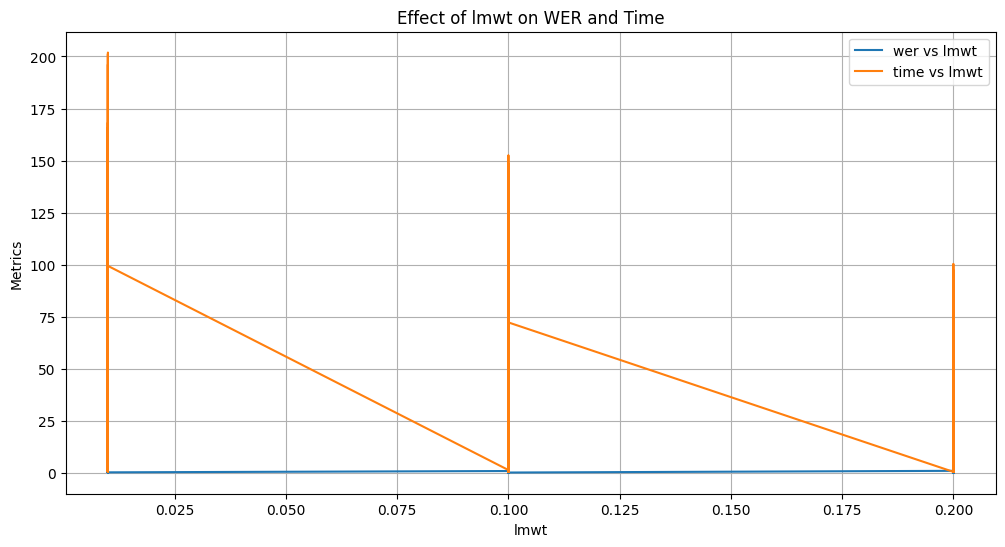

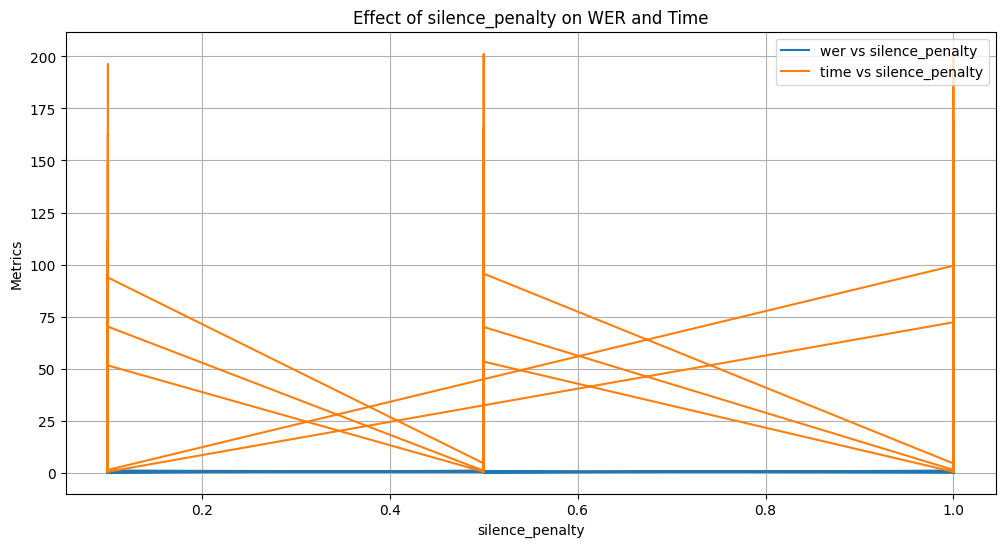

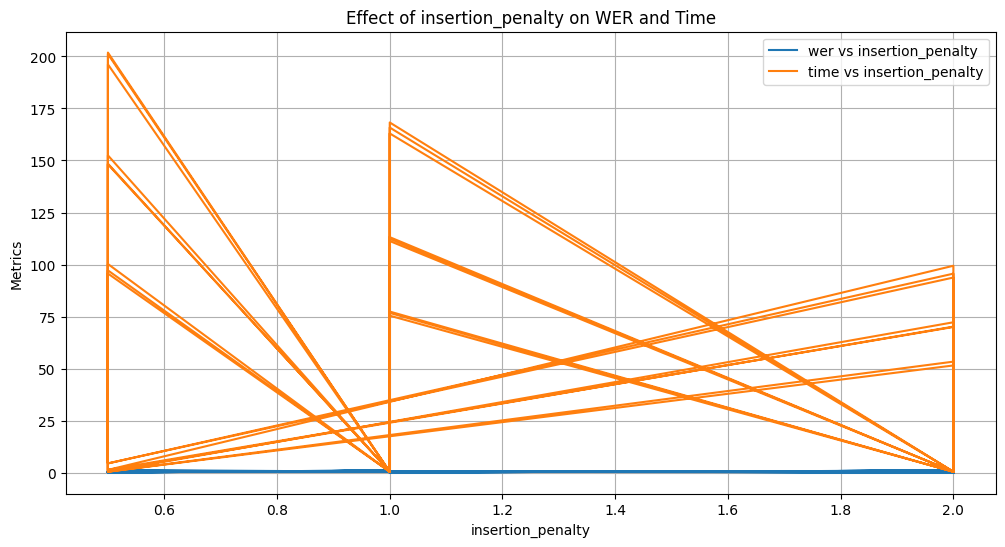

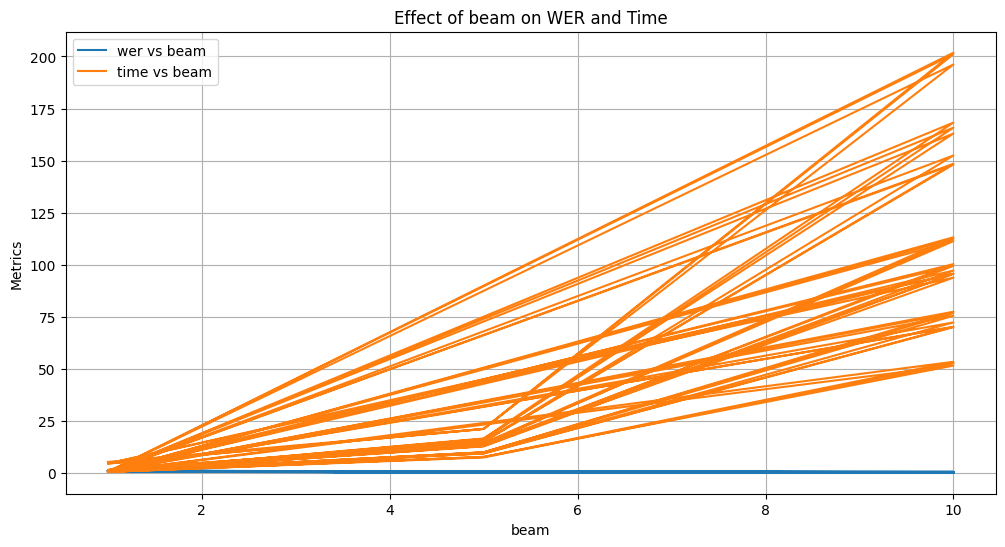

Optimal Parameters:
lmwt                  0.010000
silence_penalty       0.100000
insertion_penalty     1.000000
beam                  5.000000
wer                   0.090909
time                 16.364845
Name: 4, dtype: float64


In [61]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  

def experiment(parameters):
    results = []
    
    total_iterations = len(parameters['lmwt_factors']) * len(parameters['stay_in_silence_penalties']) * len(parameters['word_insertion_penalties']) * len(parameters['beams'])
    with tqdm(total=total_iterations, desc="Experiment Progress", unit="iteration") as pbar:
        for lmwt in parameters['lmwt_factors']:
            for silence_penalty in parameters['stay_in_silence_penalties']:
                for insertion_penalty in parameters['word_insertion_penalties']:
                    for beam in parameters['beams']:
                        t_fst = create_t_wfst()
                        l_fst = create_Lwfst_from_file(
                            stay_in_silence_penalty=silence_penalty,
                            word_insertion_penalty=insertion_penalty
                        )
                        lm_fst = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=lmwt)
                        ASR = BeamSearcher(
                            am2phone_mapping=AM_PHONES,
                            graph=OnTheFlyCompose([t_fst, l_fst, lm_fst]),
                            beam_size=beam
                        )
                        
                        start_time = time.time()
                        hyp = ASR.decode(example)
                        elapsed_time = time.time() - start_time

                        wer = jiwer.wer(example_ref, ' '.join(hyp.words))

                        results.append({
                            'lmwt': lmwt,
                            'silence_penalty': silence_penalty,
                            'insertion_penalty': insertion_penalty,
                            'beam': beam,
                            'wer': wer,
                            'time': elapsed_time
                        })
                        
                        pbar.update(1)

    return results

parameters = {
    'lmwt_factors': [0.01, 0.1, 0.2],
    'stay_in_silence_penalties': [0.1, 0.5, 1.0],
    'word_insertion_penalties': [0.5, 1.0, 2.0],
    'beams': [1, 5, 10]
}

results = experiment(parameters)

import pandas as pd

df = pd.DataFrame(results)

for param in ['lmwt', 'silence_penalty', 'insertion_penalty', 'beam']:
    plt.figure(figsize=(12, 6))
    for metric in ['wer', 'time']:
        plt.plot(
            df[param],
            df[metric],
            label=f'{metric} vs {param}'
        )
    plt.xlabel(param)
    plt.ylabel('Metrics')
    plt.legend()
    plt.title(f'Effect of {param} on WER and Time')
    plt.grid()
    plt.show()

optimal = df.loc[df['wer'].idxmin()]
print(f"Optimal Parameters:\n{optimal}")


# Дополнительное задание (2 балла)
Декодируйте всю коллекцию am_nlogprobs с подобраными ранее параметрами и посчитайте WER на этой выборке


In [77]:
import os
from jiwer import wer
t_fst = create_t_wfst()
l_fst = create_Lwfst_from_file(
    stay_in_silence_penalty=0.1,
    word_insertion_penalty=1.0
)
lm_fst = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.01)
graph = OnTheFlyCompose([t_fst, l_fst, lm_fst])

ASR = BeamSearcher(
    am2phone_mapping=AM_PHONES,
    graph=graph,
    beam_size=5
)

results = []
for file_id in tqdm(am_nlogprobs.keys(), desc="Decoding Progress"):
    txt_file = file_id + ".TXT" 

    
    with open(txt_file) as f:
        example_ref = ' '.join(f.read().replace('.', ' ').split()[2:]) 
    
    am_logprob = am_nlogprobs.get(file_id) 

    hyp = ASR.decode(am_logprob) 
    hyp_text = ' '.join(hyp.words)
    file_wer = wer(example_ref, hyp_text) 
    
    results.append({
        'file_id': file_id,
        'hypothesis': hyp_text,
        'reference': example_ref,
        'wer': file_wer
    })

Loading the LM will be faster if you build a binary file.
Reading /Users/nancyblack/Documents/asr_itmo24/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|                                                   | 0/198 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32185945970419, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-68.64530031491896, time=15, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-107.26266875775602, time=24, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-140.0255374155664, time=32, words=[], state=(0,
307 hyps. Best Hypothesis(score=-162.2282548562756, time=39, words=['she'], stat
40 hyps. Best Hypothesis(score=-179.48654996874427, time=45, words=['she'], stat
349 hyps. Best Hypothesis(scor

Found 1 hypotheses



  0%|                                                   | 0/181 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32569158771954, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.94860145415416, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.57796546548437, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-150.19481663636756, time=34, words=[], state=(0, 
245 hyps. Best Hypothesis(score=-187.91982388823234, time=43, words=[], state=(0
356 hyps. Best Hypothesis(score=-211.92231119881362, time=50, words=['dough'], s
356 hyps. Best Hypothesis(score=-227.7803021062345, time=55, words=['dough'], st
14 hyps. Best Hypothesis(score=-239.19591936535963, time=59, words=['dough'], st
817 hyps. Best Hypothesis(score=-241.82755112881614, time=64, words=['own'], sta
41 hyps. Best Hypothesis(score=-253.84223860021174, time=68, words=['own', 'ask'
3877 hyps. Best Hypothesis(score=-264.40739279880415, time=73, words=['own', 'as
156 hyps. Best Hypothesis(s

Found 2 hypotheses



  0%|                                                   | 0/248 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-30.033461192880765, time=6, words=[], state=(0, 0
267 hyps. Best Hypothesis(score=-60.05437613050825, time=13, words=[], state=(0,
1 hyps. Best Hypothesis(score=-81.50054519829914, time=18, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-102.9472044458411, time=23, words=[], state=(0, 0
266 hyps. Best Hypothesis(score=-126.2508839492283, time=28, words=[], state=(0,
18 hyps. Best Hypothesis(score=-144.13615605158168, time=33, words=[], state=(0,
2150 hyps. Best Hypothesis(score=-158.5942076998243, time=39, words=['his'], sta
943 hyps. Best Hypothesis(score=-172.54405919455078, time=43, words=['his'], sta
392 hyps. Best Hypothesis(score=-180.51168851205037, time=46, words=['his'], sta
427 hyps. Best Hypothesis(score=-184.71972221389677, time=48, words=['his'], sta
314 hyps. Best Hypothesis(score=-191.84480824314164, time=50, words=['his'], sta
1188 hyps. Best Hypothesis(

Found 2 hypotheses



  0%|                                                   | 0/175 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32057588881295, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.93780782211226, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.55232080467343, time=25, words=[], state=(0, 
704 hyps. Best Hypothesis(score=-147.1981748535947, time=34, words=['the'], stat
74 hyps. Best Hypothesis(score=-166.2137497158251, time=40, words=['the'], state
9 hyps. Best Hypothesis(score=-213.18290994131863, time=52, words=['the'], state
35 hyps. Best Hypothesis(score=-253.57306978804692, time=60, words=['the'], stat
310 hyps. Best Hypothesis(score=-279.76352566099075, time=67, words=['the', 'rea
15 hyps. Best Hypothesis(score=-294.9724027866396, time=72, words=['the', 'reaso
298 hyps. Best Hypothesis(score=-303.39386131069364, time=77, words=['the', 'rea
729 hyps. Best Hypothesis(score=-317.14344600162053, time=82, words=['the', 'rea
4079 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/187 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.33447611788002, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.95848831881423, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.58567547352234, time=25, words=[], state=(0, 
1 hyps. Best Hypothesis(score=-150.2095631166397, time=34, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-177.74013141303809, time=43, words=[], state=(0, 
371 hyps. Best Hypothesis(score=-224.209787996227, time=60, words=[], state=(0, 
41 hyps. Best Hypothesis(score=-253.0701001768672, time=69, words=['production']
310 hyps. Best Hypothesis(score=-280.22126505813947, time=76, words=['production
67 hyps. Best Hypothesis(score=-300.5413119077262, time=82, words=['production',
1370 hyps. Best Hypothesis(score=-317.7504123537946, time=87, words=['production
3128 hyps. Best Hypothesis(score=-332.6454286958387, time=91, words=['production
3243 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/165 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32324528533214, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.94897597746578, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.56438023820468, time=25, words=[], state=(0, 
361 hyps. Best Hypothesis(score=-135.93281124616658, time=34, words=[], state=(0
1 hyps. Best Hypothesis(score=-156.04162844609783, time=41, words=[], state=(0, 
283 hyps. Best Hypothesis(score=-225.782191288588, time=66, words=['pizzerias'],
3172 hyps. Best Hypothesis(score=-243.09512193062574, time=75, words=['pizzerias
1392 hyps. Best Hypothesis(score=-260.5626287474074, time=81, words=['pizzerias'
10 hyps. Best Hypothesis(score=-276.9219482306832, time=85, words=['pizzerias', 
310 hyps. Best Hypothesis(score=-317.3884089633651, time=104, words=['pizzerias'
39 hyps. Best Hypothesis(score=-337.8334022485183, time=109, words=['pizzerias',
1330 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/154 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.33028308397339, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.95156319582722, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.57554085825635, time=25, words=[], state=(0, 
443 hyps. Best Hypothesis(score=-151.21697625796966, time=34, words=[], state=(0
2006 hyps. Best Hypothesis(score=-166.14015533007478, time=41, words=['put'], st
1758 hyps. Best Hypothesis(score=-182.37616444910233, time=47, words=['put'], st
60 hyps. Best Hypothesis(score=-191.52274765160487, time=51, words=['put', 'the'
5 hyps. Best Hypothesis(score=-230.3177035208308, time=61, words=['put', 'the'],
339 hyps. Best Hypothesis(score=-242.3132553340767, time=66, words=['put', 'the'
247 hyps. Best Hypothesis(score=-256.03970308726895, time=70, words=['put', 'the
318 hyps. Best Hypothesis(score=-270.2749184229372, time=74, words=['put', 'the'
32541 hyps. Best Hypothesis

Found 1 hypotheses



  0%|                                                   | 0/176 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32789227775944, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.95485974651066, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.58288144072233, time=25, words=[], state=(0, 
47 hyps. Best Hypothesis(score=-149.36931187571483, time=34, words=[], state=(0,
866 hyps. Best Hypothesis(score=-168.49583255334363, time=42, words=[], state=(0
218 hyps. Best Hypothesis(score=-187.1917742237412, time=49, words=['drop'], sta
218 hyps. Best Hypothesis(score=-205.70500224774344, time=54, words=['drop'], st
2104 hyps. Best Hypothesis(score=-220.22286963416803, time=58, words=['drop'], s
1550 hyps. Best Hypothesis(score=-232.3218062905605, time=61, words=['drop', 'fi
1550 hyps. Best Hypothesis(score=-240.57004791437592, time=63, words=['drop', 'f
206 hyps. Best Hypothesis(score=-248.23724261842378, time=65, words=['drop', 'fi
265 hyps. Best Hypothesis(s

Found 1 hypotheses



  0%|                                                   | 0/167 [00:00<?, ?it/s]
267 hyps. Best Hypothesis(score=-12.863955153429217, time=2, words=[], state=(0,
267 hyps. Best Hypothesis(score=-25.727908764588253, time=5, words=[], state=(0,
266 hyps. Best Hypothesis(score=-35.969931326271656, time=7, words=[], state=(0,
28 hyps. Best Hypothesis(score=-49.991065991603016, time=10, words=[], state=(0,
235 hyps. Best Hypothesis(score=-66.82113529625458, time=15, words=['her'], stat
366 hyps. Best Hypothesis(score=-79.43790364986451, time=18, words=['her'], stat
240 hyps. Best Hypothesis(score=-90.41711579435376, time=21, words=['her'], stat
952 hyps. Best Hypothesis(score=-104.32384512661633, time=25, words=['her'], sta
2153 hyps. Best Hypothesis(score=-112.98121581715102, time=28, words=['her'], st
2385 hyps. Best Hypothesis(score=-117.51223201526818, time=30, words=['her'], st
1638 hyps. Best Hypothesis(score=-126.1694496761897, time=32, words=['her'], sta
625 hyps. Best Hypothesis(s

Found 14 hypotheses



  0%|                                                   | 0/122 [00:00<?, ?it/s]
1773 hyps. Best Hypothesis(score=-29.426324863181858, time=7, words=[], state=(0
208 hyps. Best Hypothesis(score=-43.221050642697605, time=11, words=[], state=(0
238 hyps. Best Hypothesis(score=-50.26218692448238, time=13, words=[], state=(0,
238 hyps. Best Hypothesis(score=-57.51267597522477, time=15, words=[], state=(0,
677 hyps. Best Hypothesis(score=-63.48861905364197, time=17, words=[], state=(0,
35 hyps. Best Hypothesis(score=-69.97905039615412, time=19, words=[], state=(0, 
1935 hyps. Best Hypothesis(score=-109.08315923248252, time=32, words=[], state=(
1469 hyps. Best Hypothesis(score=-115.12735916576949, time=37, words=['elderly']
44 hyps. Best Hypothesis(score=-127.55681349925734, time=41, words=['elderly'], 
446 hyps. Best Hypothesis(score=-121.46270090484325, time=45, words=['elderly'],
4 hyps. Best Hypothesis(score=-140.78815223930317, time=49, words=['elderly'], s
1377 hyps. Best Hypothesis(

Found 515 hypotheses



  0%|                                                   | 0/263 [00:00<?, ?it/s]
375 hyps. Best Hypothesis(score=-33.2626264653781, time=7, words=[], state=(0, 5
108 hyps. Best Hypothesis(score=-53.21893563765052, time=12, words=[], state=(0,
108 hyps. Best Hypothesis(score=-77.2273631935631, time=18, words=[], state=(0, 
295 hyps. Best Hypothesis(score=-98.89306600618066, time=25, words=[], state=(0,
605 hyps. Best Hypothesis(score=-110.83278219120976, time=31, words=['she'], sta
146 hyps. Best Hypothesis(score=-121.97543888265395, time=35, words=['she'], sta
1711 hyps. Best Hypothesis(score=-134.33657919168118, time=42, words=['she'], st
3142 hyps. Best Hypothesis(score=-141.0709848380424, time=46, words=['she'], sta
344 hyps. Best Hypothesis(score=-154.26848413211695, time=49, words=['she', 'hea
38 hyps. Best Hypothesis(score=-184.07286208896738, time=57, words=['she', 'head
759 hyps. Best Hypothesis(score=-185.9755483903402, time=61, words=['she', 'head
34 hyps. Best Hypothesis(sc

Found 2 hypotheses



  0%|                                                   | 0/207 [00:00<?, ?it/s]
337 hyps. Best Hypothesis(score=-30.830811595697433, time=6, words=[], state=(0,
186 hyps. Best Hypothesis(score=-50.62742962908064, time=11, words=[], state=(0,
335 hyps. Best Hypothesis(score=-62.41470501264873, time=14, words=[], state=(0,
585 hyps. Best Hypothesis(score=-72.55940807533673, time=17, words=[], state=(0,
2666 hyps. Best Hypothesis(score=-72.87571952275964, time=19, words=[], state=(0
720 hyps. Best Hypothesis(score=-76.8809154185323, time=21, words=['dough'], sta
720 hyps. Best Hypothesis(score=-83.15148340561278, time=23, words=['dough'], st
720 hyps. Best Hypothesis(score=-86.32321609298727, time=24, words=['dough'], st
720 hyps. Best Hypothesis(score=-89.49543840446249, time=25, words=['dough'], st
720 hyps. Best Hypothesis(score=-92.66786920017945, time=26, words=['dough'], st
720 hyps. Best Hypothesis(score=-95.84041806105618, time=27, words=['dough'], st
720 hyps. Best Hypothesis(s

Found 3 hypotheses



  0%|                                                   | 0/220 [00:00<?, ?it/s]
266 hyps. Best Hypothesis(score=-35.938789042807805, time=7, words=[], state=(0,
180 hyps. Best Hypothesis(score=-64.37736359505895, time=13, words=[], state=(0,
19 hyps. Best Hypothesis(score=-79.66602628875802, time=17, words=[], state=(0, 
86 hyps. Best Hypothesis(score=-121.51599166611364, time=34, words=[], state=(0,
2 hyps. Best Hypothesis(score=-161.30196582831084, time=43, words=['husky'], sta
307 hyps. Best Hypothesis(score=-215.38922965636897, time=55, words=['husky', 'y
149 hyps. Best Hypothesis(score=-243.3529835582293, time=63, words=['husky', 'yo
149 hyps. Best Hypothesis(score=-266.1026004774403, time=70, words=['husky', 'yo
182 hyps. Best Hypothesis(score=-286.84444851338685, time=76, words=['husky', 'y
266 hyps. Best Hypothesis(score=-304.94405345762306, time=81, words=['husky', 'y
34 hyps. Best Hypothesis(score=-317.65501067773926, time=85, words=['husky', 'yo
3609 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/229 [00:00<?, ?it/s]
267 hyps. Best Hypothesis(score=-12.857927247227437, time=2, words=[], state=(0,
267 hyps. Best Hypothesis(score=-25.71573084461929, time=5, words=[], state=(0, 
266 hyps. Best Hypothesis(score=-35.92898732929087, time=7, words=[], state=(0, 
1895 hyps. Best Hypothesis(score=-42.20286547925696, time=9, words=[], state=(0,
989 hyps. Best Hypothesis(score=-48.87857448125476, time=11, words=[], state=(0,
586 hyps. Best Hypothesis(score=-55.99726961396698, time=13, words=[], state=(0,
566 hyps. Best Hypothesis(score=-60.440971827710996, time=15, words=[], state=(0
798 hyps. Best Hypothesis(score=-67.75469393536224, time=17, words=['hum'], stat
798 hyps. Best Hypothesis(score=-73.12182452355803, time=18, words=['hum'], stat
923 hyps. Best Hypothesis(score=-77.86041920776356, time=19, words=['hum'], stat
383 hyps. Best Hypothesis(score=-81.75336607986664, time=20, words=['hum'], stat
600 hyps. Best Hypothesis(s

Found 1 hypotheses



  0%|                                                   | 0/371 [00:00<?, ?it/s]
731 hyps. Best Hypothesis(score=-24.768467110204117, time=5, words=[], state=(0,
310 hyps. Best Hypothesis(score=-40.69897062610019, time=9, words=[], state=(0, 
28 hyps. Best Hypothesis(score=-48.67723575540779, time=11, words=[], state=(0, 
822 hyps. Best Hypothesis(score=-91.28774836012083, time=23, words=[], state=(0,
796 hyps. Best Hypothesis(score=-102.49597563999194, time=27, words=['fuss'], st
780 hyps. Best Hypothesis(score=-111.85517642205501, time=30, words=['fuss'], st
57 hyps. Best Hypothesis(score=-112.26201814152508, time=32, words=['fuss'], sta
172 hyps. Best Hypothesis(score=-116.14725980961937, time=51, words=['fuss', 'th
108 hyps. Best Hypothesis(score=-50.79787107507686, time=95, words=['fuss', 'the
32 hyps. Best Hypothesis(score=-91.94035996201958, time=112, words=['fuss', 'the
355 hyps. Best Hypothesis(score=-121.26699908785511, time=128, words=['fuss', 't
390 hyps. Best Hypothesis(s

Found 1 hypotheses



  0%|                                                   | 0/136 [00:00<?, ?it/s]
313 hyps. Best Hypothesis(score=-31.607451435392544, time=7, words=[], state=(0,
365 hyps. Best Hypothesis(score=-42.39379178970833, time=10, words=[], state=(0,
365 hyps. Best Hypothesis(score=-49.60461870901554, time=12, words=[], state=(0,
365 hyps. Best Hypothesis(score=-56.804412650249986, time=14, words=[], state=(0
471 hyps. Best Hypothesis(score=-57.68233363815892, time=16, words=[], state=(0,
3052 hyps. Best Hypothesis(score=-53.72520013414086, time=18, words=[], state=(0
393 hyps. Best Hypothesis(score=-64.2673462130129, time=20, words=[], state=(0, 
393 hyps. Best Hypothesis(score=-74.85829183738909, time=22, words=[], state=(0,
205 hyps. Best Hypothesis(score=-83.303886965218, time=24, words=[], state=(0, 2
114 hyps. Best Hypothesis(score=-93.58660719769016, time=29, words=[], state=(0,
1444 hyps. Best Hypothesis(score=-98.74538576137137, time=35, words=[], state=(0
1026 hyps. Best Hypothesis(

Found 2 hypotheses



  0%|                                                   | 0/221 [00:00<?, ?it/s]
245 hyps. Best Hypothesis(score=-34.851161591242025, time=7, words=[], state=(0,
1041 hyps. Best Hypothesis(score=-66.33547368556982, time=15, words=['the'], sta
242 hyps. Best Hypothesis(score=-80.83802112061626, time=19, words=['the'], stat
285 hyps. Best Hypothesis(score=-88.08632531424767, time=21, words=['the'], stat
1148 hyps. Best Hypothesis(score=-95.14399396642513, time=23, words=['the'], sta
2745 hyps. Best Hypothesis(score=-99.53686343499548, time=25, words=['the'], sta
548 hyps. Best Hypothesis(score=-103.31203873753242, time=27, words=['the', "'em
814 hyps. Best Hypothesis(score=-106.08540104470154, time=28, words=['the', "'em
801 hyps. Best Hypothesis(score=-108.79077710194696, time=29, words=['the', "'em
798 hyps. Best Hypothesis(score=-111.46441964631396, time=30, words=['the', "'em
974 hyps. Best Hypothesis(score=-113.14195023162546, time=31, words=['the'], sta
4 hyps. Best Hypothesis(sco

Found 2 hypotheses



  0%|                                                   | 0/210 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32565390850365, time=7, words=[], state=(0, 0,
1 hyps. Best Hypothesis(score=-72.94863234580382, time=16, words=[], state=(0, 0
1 hyps. Best Hypothesis(score=-111.56684163072444, time=25, words=[], state=(0, 
75 hyps. Best Hypothesis(score=-152.04087847703022, time=34, words=[], state=(0,
1691 hyps. Best Hypothesis(score=-164.53899263699063, time=43, words=[], state=(
1411 hyps. Best Hypothesis(score=-179.88493198545865, time=49, words=['cheap'], 
847 hyps. Best Hypothesis(score=-189.8684139441745, time=53, words=['cheap'], st
145 hyps. Best Hypothesis(score=-196.49017704105626, time=56, words=['cheap'], s
124 hyps. Best Hypothesis(score=-209.65880463637149, time=60, words=['cheap'], s
124 hyps. Best Hypothesis(score=-222.81637822248757, time=64, words=['cheap'], s
123 hyps. Best Hypothesis(score=-235.63774409094657, time=68, words=['cheap'], s
2040 hyps. Best Hypothesis(

Found 6 hypotheses



  0%|                                                   | 0/201 [00:00<?, ?it/s]
405 hyps. Best Hypothesis(score=-34.6966328458832, time=7, words=[], state=(0, 7
245 hyps. Best Hypothesis(score=-54.479361742425816, time=12, words=[], state=(0
418 hyps. Best Hypothesis(score=-66.27651317325497, time=15, words=[], state=(0,
589 hyps. Best Hypothesis(score=-76.86377083647979, time=18, words=[], state=(0,
591 hyps. Best Hypothesis(score=-79.27772216995673, time=20, words=[], state=(0,
758 hyps. Best Hypothesis(score=-81.98214911035201, time=22, words=[], state=(0,
2333 hyps. Best Hypothesis(score=-82.59341557130729, time=24, words=['dough', 'o
1011 hyps. Best Hypothesis(score=-87.73740928759372, time=25, words=['dough', 'o
1030 hyps. Best Hypothesis(score=-92.6851154901696, time=26, words=['dough', 'ow
31 hyps. Best Hypothesis(score=-97.1187610385725, time=27, words=['dough', 'own'
30 hyps. Best Hypothesis(score=-111.30211089226587, time=30, words=['dough', 'ow
30 hyps. Best Hypothesis(sc

Found 1 hypotheses



  0%|                                                   | 0/192 [00:00<?, ?it/s]
683 hyps. Best Hypothesis(score=-33.93600885320711, time=7, words=[], state=(0, 
873 hyps. Best Hypothesis(score=-48.50351642320244, time=11, words=[], state=(0,
359 hyps. Best Hypothesis(score=-55.05030613489211, time=13, words=[], state=(0,
266 hyps. Best Hypothesis(score=-62.47224771921667, time=15, words=[], state=(0,
431 hyps. Best Hypothesis(score=-70.44049728455549, time=17, words=[], state=(0,
277 hyps. Best Hypothesis(score=-78.1530542486904, time=19, words=[], state=(0, 
262 hyps. Best Hypothesis(score=-86.48912282524061, time=21, words=[], state=(0,
2279 hyps. Best Hypothesis(score=-90.98450083733803, time=23, words=['cow'], sta
2165 hyps. Best Hypothesis(score=-96.60951853769294, time=25, words=['cow'], sta
2165 hyps. Best Hypothesis(score=-99.42381058794437, time=26, words=['cow'], sta
2165 hyps. Best Hypothesis(score=-102.23757973968571, time=27, words=['cow'], st
2165 hyps. Best Hypothesis(

Found 2 hypotheses



  0%|                                                   | 0/189 [00:00<?, ?it/s]
108 hyps. Best Hypothesis(score=-33.71692832836142, time=7, words=[], state=(0, 
325 hyps. Best Hypothesis(score=-59.492543178934376, time=14, words=[], state=(0
80 hyps. Best Hypothesis(score=-74.9009108655321, time=21, words=['she'], state=
840 hyps. Best Hypothesis(score=-91.73330097613415, time=28, words=['she'], stat
22 hyps. Best Hypothesis(score=-105.08662761875986, time=32, words=['she', 'had'
394 hyps. Best Hypothesis(score=-103.45865258902074, time=38, words=['she', 'had
249 hyps. Best Hypothesis(score=-116.75572096675471, time=42, words=['she', 'had
1712 hyps. Best Hypothesis(score=-126.38449314010991, time=45, words=['she', 'ha
8268 hyps. Best Hypothesis(score=-118.42186311349677, time=48, words=['she', 'ha
9710 hyps. Best Hypothesis(score=-125.01143368012815, time=50, words=['she', 'ha
3646 hyps. Best Hypothesis(score=-129.4499468053338, time=52, words=['she', 'had
3646 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/147 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.31504815522063, time=7, words=[], state=(0, 0,
186 hyps. Best Hypothesis(score=-69.05040447500764, time=15, words=[], state=(0,
788 hyps. Best Hypothesis(score=-88.01244763500686, time=20, words=[], state=(0,
1083 hyps. Best Hypothesis(score=-99.28117231092028, time=24, words=[], state=(0
200 hyps. Best Hypothesis(score=-107.71840020722806, time=27, words=["don't"], s
207 hyps. Best Hypothesis(score=-120.36673160157972, time=31, words=["don't"], s
1024 hyps. Best Hypothesis(score=-138.42302302535552, time=39, words=["don't"], 
608 hyps. Best Hypothesis(score=-149.09861657684505, time=42, words=["don't", 'a
124 hyps. Best Hypothesis(score=-156.0613086151348, time=44, words=["don't", 'as
60 hyps. Best Hypothesis(score=-162.20186682806695, time=46, words=["don't", 'as
1246 hyps. Best Hypothesis(score=-164.364593124678, time=48, words=["don't", 'as
31 hyps. Best Hypothesis(sc

Found 1 hypotheses



  0%|                                                   | 0/275 [00:00<?, ?it/s]
1489 hyps. Best Hypothesis(score=-31.634000721471033, time=7, words=[], state=(0
298 hyps. Best Hypothesis(score=-41.154962738642695, time=10, words=[], state=(0
499 hyps. Best Hypothesis(score=-47.689299368762434, time=12, words=[], state=(0
183 hyps. Best Hypothesis(score=-55.911504721415625, time=14, words=[], state=(0
196 hyps. Best Hypothesis(score=-72.33386095983742, time=18, words=[], state=(0,
48 hyps. Best Hypothesis(score=-82.78644435757904, time=21, words=['in'], state=
48 hyps. Best Hypothesis(score=-102.1847471729798, time=26, words=['in'], state=
316 hyps. Best Hypothesis(score=-115.66718746451826, time=30, words=['in'], stat
316 hyps. Best Hypothesis(score=-131.421643221756, time=33, words=['in'], state=
788 hyps. Best Hypothesis(score=-145.53848590786498, time=36, words=['in'], stat
614 hyps. Best Hypothesis(score=-144.74993856135396, time=38, words=['in', 'wage
10 hyps. Best Hypothesis(sc

Found 1 hypotheses



  0%|                                                   | 0/169 [00:00<?, ?it/s]
267 hyps. Best Hypothesis(score=-12.862707460576004, time=2, words=[], state=(0,
267 hyps. Best Hypothesis(score=-25.718045845700143, time=5, words=[], state=(0,
266 hyps. Best Hypothesis(score=-36.23310015621482, time=7, words=[], state=(0, 
279 hyps. Best Hypothesis(score=-51.63190737753679, time=10, words=[], state=(0,
37 hyps. Best Hypothesis(score=-60.9341387609517, time=13, words=[], state=(0, 1
233 hyps. Best Hypothesis(score=-74.84949193892271, time=17, words=[], state=(0,
649 hyps. Best Hypothesis(score=-88.35457802660265, time=20, words=[], state=(0,
619 hyps. Best Hypothesis(score=-97.87951262268524, time=23, words=['he'], state
621 hyps. Best Hypothesis(score=-104.82144626555007, time=25, words=['he'], stat
565 hyps. Best Hypothesis(score=-111.6447267936258, time=27, words=['heave'], st
733 hyps. Best Hypothesis(score=-118.74390644973535, time=29, words=['heave'], s
228 hyps. Best Hypothesis(s

Found 2 hypotheses



  0%|                                                   | 0/209 [00:00<?, ?it/s]
428 hyps. Best Hypothesis(score=-34.01029940911526, time=7, words=[], state=(0, 
3 hyps. Best Hypothesis(score=-52.91940089523112, time=15, words=[], state=(0, 1
3 hyps. Best Hypothesis(score=-121.69291312427657, time=33, words=[], state=(0, 
1476 hyps. Best Hypothesis(score=-149.48135343864953, time=42, words=[], state=(
1476 hyps. Best Hypothesis(score=-163.37139184344906, time=48, words=['materials
1 hyps. Best Hypothesis(score=-180.5104212252269, time=52, words=['materials'], 
721 hyps. Best Hypothesis(score=-203.3025939124399, time=58, words=['materials']
721 hyps. Best Hypothesis(score=-211.75875563501987, time=61, words=['materials'
721 hyps. Best Hypothesis(score=-220.21262203593133, time=64, words=['materials'
49 hyps. Best Hypothesis(score=-227.6181661122844, time=66, words=['materials'],
339 hyps. Best Hypothesis(score=-274.6082896683016, time=84, words=['materials']
91 hyps. Best Hypothesis(sc

Found 1 hypotheses



  0%|                                                   | 0/145 [00:00<?, ?it/s]
6971 hyps. Best Hypothesis(score=-26.549624975257817, time=7, words=[], state=(0
1111 hyps. Best Hypothesis(score=-30.01576573857283, time=8, words=[], state=(0,
1035 hyps. Best Hypothesis(score=-33.539641594825795, time=9, words=[], state=(0
2801 hyps. Best Hypothesis(score=-36.36822008319895, time=10, words=[], state=(0
3565 hyps. Best Hypothesis(score=-39.60344732664565, time=11, words=[], state=(0
7729 hyps. Best Hypothesis(score=-37.74916657305637, time=12, words=[], state=(0
8620 hyps. Best Hypothesis(score=-39.03712439919326, time=13, words=['are'], sta
4595 hyps. Best Hypothesis(score=-42.248187937175565, time=14, words=['are'], st
2860 hyps. Best Hypothesis(score=-44.936856369652446, time=15, words=['are'], st
1096 hyps. Best Hypothesis(score=-49.05981621358153, time=16, words=['are'], sta
1096 hyps. Best Hypothesis(score=-53.184868021984556, time=17, words=['are'], st
1096 hyps. Best Hypothesis(

Found 2 hypotheses



  0%|                                                   | 0/109 [00:00<?, ?it/s]
564 hyps. Best Hypothesis(score=-33.79258707993656, time=7, words=[], state=(0, 
2222 hyps. Best Hypothesis(score=-43.638814598661085, time=10, words=[], state=(
2222 hyps. Best Hypothesis(score=-49.27626342411436, time=12, words=[], state=(0
2222 hyps. Best Hypothesis(score=-52.09521840143131, time=13, words=[], state=(0
2222 hyps. Best Hypothesis(score=-54.91336773763122, time=14, words=[], state=(0
2267 hyps. Best Hypothesis(score=-57.41914422008449, time=15, words=[], state=(0
64 hyps. Best Hypothesis(score=-60.173409095417526, time=16, words=['a'], state=
731 hyps. Best Hypothesis(score=-96.72444336938946, time=26, words=['a'], state=
1206 hyps. Best Hypothesis(score=-98.35963380961415, time=29, words=['a', 'small
350 hyps. Best Hypothesis(score=-109.91607143464373, time=32, words=['a', 'small
18 hyps. Best Hypothesis(score=-124.40877598636176, time=35, words=['a', 'small'
4885 hyps. Best Hypothesis(

Found 3 hypotheses



  0%|                                                   | 0/124 [00:00<?, ?it/s]
2149 hyps. Best Hypothesis(score=-27.990674677265332, time=6, words=[], state=(0
465 hyps. Best Hypothesis(score=-46.88406236519292, time=13, words=[], state=(0,
577 hyps. Best Hypothesis(score=-59.94510570438237, time=16, words=[], state=(0,
98 hyps. Best Hypothesis(score=-68.68353320944449, time=19, words=['a'], state=(
33 hyps. Best Hypothesis(score=-93.08235693912083, time=26, words=['a'], state=(
151 hyps. Best Hypothesis(score=-109.21027269439047, time=30, words=['a'], state
461 hyps. Best Hypothesis(score=-124.30697008872806, time=33, words=['a'], state
310 hyps. Best Hypothesis(score=-135.58175614148868, time=36, words=['a', 'chose
310 hyps. Best Hypothesis(score=-147.91996449910357, time=39, words=['a', 'chose
5 hyps. Best Hypothesis(score=-161.31385697045104, time=42, words=['a', 'chosen'
40 hyps. Best Hypothesis(score=-183.98611838399188, time=47, words=['a', 'chosen
653 hyps. Best Hypothesis(s

Found 2 hypotheses



  0%|                                                   | 0/175 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.32178134711872, time=7, words=[], state=(0, 0,
283 hyps. Best Hypothesis(score=-65.01032632586012, time=15, words=[], state=(0,
1670 hyps. Best Hypothesis(score=-79.25822603241306, time=19, words=[], state=(0
826 hyps. Best Hypothesis(score=-88.857645570533, time=22, words=[], state=(0, 2
605 hyps. Best Hypothesis(score=-94.6126207478173, time=24, words=[], state=(0, 
55 hyps. Best Hypothesis(score=-102.86715696810946, time=26, words=['only'], sta
1182 hyps. Best Hypothesis(score=-118.2239840993774, time=30, words=['only', 'th
929 hyps. Best Hypothesis(score=-126.36308501266647, time=32, words=['only', 'th
224 hyps. Best Hypothesis(score=-134.16895587608155, time=34, words=['only', 'th
224 hyps. Best Hypothesis(score=-142.09338851555975, time=36, words=['only', 'th
224 hyps. Best Hypothesis(score=-150.0193733489292, time=38, words=['only', 'the
1673 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/190 [00:00<?, ?it/s]
302 hyps. Best Hypothesis(score=-30.303109365093302, time=6, words=[], state=(0,
954 hyps. Best Hypothesis(score=-57.48874816795886, time=13, words=['the'], stat
120 hyps. Best Hypothesis(score=-71.95810721011631, time=17, words=['the'], stat
124 hyps. Best Hypothesis(score=-90.94501556736118, time=22, words=['the'], stat
124 hyps. Best Hypothesis(score=-102.95474955120403, time=25, words=['the'], sta
2751 hyps. Best Hypothesis(score=-103.98705874725715, time=28, words=['the', 'fi
1038 hyps. Best Hypothesis(score=-114.78762417495327, time=30, words=['the', 'fi
551 hyps. Best Hypothesis(score=-120.3485098504087, time=32, words=['the', 'fish
561 hyps. Best Hypothesis(score=-122.01759690139161, time=34, words=['the', 'fis
53 hyps. Best Hypothesis(score=-130.62797633688055, time=36, words=['the', 'fish
758 hyps. Best Hypothesis(score=-153.68611724496137, time=44, words=['the', 'fis
677 hyps. Best Hypothesis(s

Found 1 hypotheses



  0%|                                                   | 0/186 [00:00<?, ?it/s]
109 hyps. Best Hypothesis(score=-33.86890235027834, time=7, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-53.88625193914349, time=12, words=[], state=(0,
325 hyps. Best Hypothesis(score=-75.04759544751016, time=18, words=[], state=(0,
709 hyps. Best Hypothesis(score=-84.55457152087922, time=23, words=['she'], stat
66 hyps. Best Hypothesis(score=-98.38232794817947, time=27, words=['she'], state
751 hyps. Best Hypothesis(score=-106.76157776790001, time=31, words=['she'], sta
67 hyps. Best Hypothesis(score=-119.85591075702419, time=34, words=['she', 'head
905 hyps. Best Hypothesis(score=-139.05627922913834, time=39, words=['she', 'hea
1104 hyps. Best Hypothesis(score=-144.436209519407, time=41, words=['she', 'head
5683 hyps. Best Hypothesis(score=-139.8215968917369, time=43, words=['she', 'hea
7667 hyps. Best Hypothesis(score=-149.26227554517445, time=45, words=['she', 'he
912 hyps. Best Hypothesis(s

Found 2 hypotheses



  0%|                                                   | 0/172 [00:00<?, ?it/s]
1 hyps. Best Hypothesis(score=-34.30166759617574, time=7, words=[], state=(0, 0,
186 hyps. Best Hypothesis(score=-68.61252852941033, time=15, words=[], state=(0,
585 hyps. Best Hypothesis(score=-86.94400011450553, time=20, words=[], state=(0,
746 hyps. Best Hypothesis(score=-95.51331815299382, time=23, words=["don't"], st
190 hyps. Best Hypothesis(score=-105.0092794753924, time=26, words=["don't"], st
190 hyps. Best Hypothesis(score=-117.6979000406677, time=30, words=["don't"], st
10 hyps. Best Hypothesis(score=-130.02444191254918, time=34, words=["don't"], st
2414 hyps. Best Hypothesis(score=-141.55091007229166, time=41, words=["don't"], 
711 hyps. Best Hypothesis(score=-152.33148876305214, time=44, words=["don't", 'a
356 hyps. Best Hypothesis(score=-158.4590550670466, time=46, words=["don't", 'as
356 hyps. Best Hypothesis(score=-164.47664712456893, time=48, words=["don't", 'a
2430 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/172 [00:00<?, ?it/s]
425 hyps. Best Hypothesis(score=-35.24167979274359, time=7, words=[], state=(0, 
173 hyps. Best Hypothesis(score=-45.75674719494959, time=11, words=[], state=(0,
177 hyps. Best Hypothesis(score=-58.13261966159536, time=15, words=[], state=(0,
176 hyps. Best Hypothesis(score=-68.20557841302487, time=18, words=[], state=(0,
1759 hyps. Best Hypothesis(score=-76.4992869493692, time=21, words=[], state=(0,
2149 hyps. Best Hypothesis(score=-81.92790693675519, time=23, words=[], state=(0
18 hyps. Best Hypothesis(score=-88.49222534827868, time=25, words=[], state=(0, 
4285 hyps. Best Hypothesis(score=-103.31288468817274, time=31, words=[], state=(
907 hyps. Best Hypothesis(score=-108.65512500596788, time=33, words=['dances'], 
854 hyps. Best Hypothesis(score=-115.634554738768, time=35, words=['dances'], st
1389 hyps. Best Hypothesis(score=-122.03270738423731, time=37, words=['dances'],
1970 hyps. Best Hypothesis(

Found 1 hypotheses



  0%|                                                   | 0/146 [00:00<?, ?it/s]
550 hyps. Best Hypothesis(score=-32.22850736048645, time=7, words=[], state=(0, 
450 hyps. Best Hypothesis(score=-39.65408028205316, time=9, words=[], state=(0, 
760 hyps. Best Hypothesis(score=-47.05457206968427, time=11, words=[], state=(0,
3084 hyps. Best Hypothesis(score=-49.96127916050719, time=12, words=['my'], stat
3107 hyps. Best Hypothesis(score=-54.08216632416038, time=13, words=['my'], stat
3107 hyps. Best Hypothesis(score=-58.20542102248828, time=14, words=['my'], stat
3107 hyps. Best Hypothesis(score=-62.32893683200113, time=15, words=['my'], stat
3107 hyps. Best Hypothesis(score=-66.45059027669285, time=16, words=['my'], stat
3107 hyps. Best Hypothesis(score=-70.56989427206294, time=17, words=['my'], stat
2563 hyps. Best Hypothesis(score=-73.65496404567764, time=18, words=['my'], stat
1003 hyps. Best Hypothesis(score=-76.84712932905988, time=19, words=['my'], stat
881 hyps. Best Hypothesis(s

Found 4 hypotheses



  0%|                                                   | 0/304 [00:00<?, ?it/s]
266 hyps. Best Hypothesis(score=-36.189338283078435, time=7, words=[], state=(0,
420 hyps. Best Hypothesis(score=-56.574025349803925, time=13, words=[], state=(0
1724 hyps. Best Hypothesis(score=-64.6109053831721, time=16, words=['he'], state
4349 hyps. Best Hypothesis(score=-69.89971185408955, time=18, words=['he'], stat
2937 hyps. Best Hypothesis(score=-75.60108056919589, time=20, words=['he', 'ear'
1067 hyps. Best Hypothesis(score=-79.93996531344474, time=21, words=['he', 'ear'
1067 hyps. Best Hypothesis(score=-84.5706888824426, time=22, words=['he', 'ear']
1067 hyps. Best Hypothesis(score=-88.86553163545763, time=23, words=['he', 'ear'
1236 hyps. Best Hypothesis(score=-92.5705107305213, time=24, words=['he', 'ear']
1880 hyps. Best Hypothesis(score=-95.37021746096859, time=25, words=['he', 'ear'
1382 hyps. Best Hypothesis(score=-98.33190188536705, time=26, words=['he', 'ear'
510 hyps. Best Hypothesis(s

Found 1 hypotheses



  0%|                                                   | 0/145 [00:00<?, ?it/s]
27 hyps. Best Hypothesis(score=-25.698584301950948, time=5, words=[], state=(0, 
8653 hyps. Best Hypothesis(score=-31.811879127692478, time=11, words=['the'], st
3887 hyps. Best Hypothesis(score=-43.08463322331504, time=14, words=['the'], sta
4152 hyps. Best Hypothesis(score=-50.714728948115166, time=16, words=['the'], st
1298 hyps. Best Hypothesis(score=-53.84048167746205, time=17, words=['the'], sta
602 hyps. Best Hypothesis(score=-56.94903175754341, time=18, words=['the'], stat
602 hyps. Best Hypothesis(score=-63.207263503542535, time=20, words=['the'], sta
602 hyps. Best Hypothesis(score=-66.3254098643775, time=21, words=['the'], state
602 hyps. Best Hypothesis(score=-72.47953397714356, time=23, words=['the'], stat
609 hyps. Best Hypothesis(score=-76.99465701845652, time=25, words=['the'], stat
292 hyps. Best Hypothesis(score=-73.99370656333163, time=26, words=['the'], stat
1905 hyps. Best Hypothesis(

Found 4 hypotheses



  0%|                                                   | 0/195 [00:00<?, ?it/s]
508 hyps. Best Hypothesis(score=-33.759351840998114, time=7, words=[], state=(0,
508 hyps. Best Hypothesis(score=-49.876827238122054, time=11, words=[], state=(0
66 hyps. Best Hypothesis(score=-61.26255408118103, time=14, words=[], state=(0, 
313 hyps. Best Hypothesis(score=-86.70377112246851, time=21, words=[], state=(0,
313 hyps. Best Hypothesis(score=-103.19845619203014, time=25, words=[], state=(0
204 hyps. Best Hypothesis(score=-114.52937669302483, time=28, words=['cliff'], s
55 hyps. Best Hypothesis(score=-123.89966855810965, time=31, words=['cliff'], st
741 hyps. Best Hypothesis(score=-128.2040847570699, time=35, words=['cliff', 'wa
721 hyps. Best Hypothesis(score=-136.65794897478662, time=38, words=['cliff', 'w
721 hyps. Best Hypothesis(score=-142.29594302755794, time=40, words=['cliff', 'w
721 hyps. Best Hypothesis(score=-147.9333766358406, time=42, words=['cliff', 'wa
734 hyps. Best Hypothesis(s

Found 1 hypotheses



  0%|                                                   | 0/289 [00:00<?, ?it/s]
66 hyps. Best Hypothesis(score=-30.637001778256664, time=7, words=[], state=(0, 
108 hyps. Best Hypothesis(score=-39.970270527223605, time=10, words=[], state=(0
109 hyps. Best Hypothesis(score=-48.56559417054288, time=13, words=[], state=(0,
234 hyps. Best Hypothesis(score=-55.073567989921955, time=16, words=[], state=(0
234 hyps. Best Hypothesis(score=-65.65469841000596, time=18, words=[], state=(0,
180 hyps. Best Hypothesis(score=-72.46924438317771, time=20, words=['each'], sta
180 hyps. Best Hypothesis(score=-89.39090056250959, time=24, words=['each'], sta
116 hyps. Best Hypothesis(score=-100.61337489960306, time=27, words=['each'], st
320 hyps. Best Hypothesis(score=-192.50737274990155, time=54, words=['each'], st
11208 hyps. Best Hypothesis(score=-190.35151378575014, time=60, words=['each', '
11044 hyps. Best Hypothesis(score=-193.83739836121455, time=61, words=['each', '
11044 hyps. Best Hypothesis

Found 9 hypotheses



  0%|                                                   | 0/150 [00:00<?, ?it/s]
134 hyps. Best Hypothesis(score=-30.81207760909202, time=6, words=[], state=(0, 
148 hyps. Best Hypothesis(score=-98.68605408298032, time=23, words=[], state=(0,
1273 hyps. Best Hypothesis(score=-138.55141309347582, time=35, words=['chain'], 
773 hyps. Best Hypothesis(score=-152.8418573449716, time=43, words=['chain', 'ma
1082 hyps. Best Hypothesis(score=-170.56198799656212, time=48, words=['chain', '
1832 hyps. Best Hypothesis(score=-183.32899195926635, time=52, words=['chain', '
364 hyps. Best Hypothesis(score=-195.07731112993082, time=55, words=['chain', 'm
486 hyps. Best Hypothesis(score=-208.7402057021534, time=59, words=['chain', 'ma
960 hyps. Best Hypothesis(score=-218.7978316540523, time=62, words=['chain', 'ma
608 hyps. Best Hypothesis(score=-226.9453152658624, time=64, words=['chain', 'ma
608 hyps. Best Hypothesis(score=-235.09859596349042, time=66, words=['chain', 'm
48 hyps. Best Hypothesis(sc

Found 2 hypotheses



  0%|                                                   | 0/160 [00:00<?, ?it/s]
68 hyps. Best Hypothesis(score=-30.49062628729012, time=6, words=[], state=(0, 3
3 hyps. Best Hypothesis(score=-75.87004374250859, time=16, words=[], state=(0, 3
848 hyps. Best Hypothesis(score=-99.59209603916072, time=24, words=[], state=(0,
5 hyps. Best Hypothesis(score=-118.35242821282621, time=29, words=[], state=(0, 
1139 hyps. Best Hypothesis(score=-153.46380267170036, time=39, words=['youngster
108 hyps. Best Hypothesis(score=-176.08639699542732, time=45, words=['youngsters
119 hyps. Best Hypothesis(score=-201.0370211519533, time=51, words=['youngsters'
2829 hyps. Best Hypothesis(score=-209.37896173458864, time=56, words=['youngster
1040 hyps. Best Hypothesis(score=-225.04322461626157, time=60, words=['youngster
138 hyps. Best Hypothesis(score=-235.99511247965265, time=63, words=['youngsters
158 hyps. Best Hypothesis(score=-253.69473095256885, time=68, words=['youngsters
1482 hyps. Best Hypothesis(

Found 6 hypotheses


In [78]:
average_wer = sum(r['wer'] for r in results) / len(results)
print(f"Средний WER: {average_wer:.2f}")

Средний WER: 0.65
